<h1 style="color:blue;"> Predicting the Creditworthiness for Loan </h1>

# Business Problem:

80% of rural individuals and businesses find it difficult to access formal credit. The data science team at a rural-focused fintech aims to brige this credit gap in the rural market by building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

Formal credit in the rural economy can be deployed via two main financial instruments:

1. __Buy Now, Pay Later__: Where a customer can avail credit at the point of sale to purchase goods.
2. __Supply Chain Financing__: Where a business partnered with the fintech can finance invoices and/or purchase orders to bridge the gap in payable and receivable credit cycles.

This case study will focus on the underwriting process behind __Supply Chain Financing__.

# Importing Libaries

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
from prettytable import PrettyTable
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler 

!pip install -q imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [177]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

__Data Dimension__

In [178]:
df.shape

(396030, 27)

__Summary:__

We have 396030 data points, and 27 features

__How the data looks like?__

In [179]:
pd.set_option('display.max_columns', None)
df.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT    117000.0   
1          Credit analyst     4 years       MORTGAGE     65000.0   
2             Statistician   < 1 year           RENT     43057.0   
3          Client Advocate    6 years           RENT     54000.0   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0   

  verification_status   issue_d  loan_status             purpose  \
0        Not Verified  Jan-2015   Fully Paid            vacation   
1        Not Verified  Jan-2015   Fully Paid  debt_consolidation   
2     Source Verified  Jan-2015   Fully Paid         credit_card   
3        Not Verified  Nov-2014   Fully Paid         credit_card   
4            Verified  Apr-2013  Charged Off         credit_card   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0                 Vacation  26.24         Jun-1990      16.0      0.0   
1       Debt consolidation  22.05         Jul-2004      17.0      0.0   
2  Credit card refinancing  12.79         Aug-2007      13.0      0.0   
3  Credit card refinancing   2.60         Sep-2006       6.0      0.0   
4    Credit Card Refinance  33.95         Mar-1999      13.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   
1    20131.0        53.3       27.0                   f       INDIVIDUAL   
2    11987.0        92.2       26.0                   f       INDIVIDUAL   
3     5472.0        21.5       13.0                   f       INDIVIDUAL   
4    24584.0        69.8       43.0                   f       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   
1       3.0                   0.0   
2       0.0                   0.0   
3       0.0                   0.0   
4       1.0                   0.0   

                                             address  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113  
3            823 Reid Ford\r\nDelacruzside, MA 00813  
4             679 Luna Roads\r\nGreggshire, VA 11650

__Column names:__

In [180]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

**We have following informations about the columns:**
<ol>
<li>loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</li>
<li>term : The number of payments on the loan. Values are in months and can be either 36 or 60.</li>
<li>int_rate : Interest Rate on the loan</li>
<li>installment : The monthly payment owed by the borrower if the loan originates.</li>
<li>grade : Company assigned loan grade</li>
<li>sub_grade : Company assigned loan subgrade</li>
<li>emp_title :The job title supplied by the Borrower when applying for the loan.*</li>
<li>emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</li>
<li>home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report. </li>
<li>annual_inc : The self-reported annual income provided by the borrower during registration.</li>
<li>verification_status : Indicates if income was verified by Company, not verified, or if the income source was verified</li>
<li>issue_d : The month which the loan was funded</li>
<li>loan_status : Current status of the loan - Target Variable</li>
<li>purpose : A category provided by the borrower for the loan request.</li>
<li>title : The loan title provided by the borrower</li>
<li>dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested Company loan, divided by the borrower’s self-reported monthly income.</li>
<li>earliest_cr_line :The month the borrower's earliest reported credit line was opened</li>
<li>open_acc : The number of open credit lines in the borrower's credit file.</li>
<li>pub_rec : Number of derogatory public records</li>
<li>revol_bal : Total credit revolving balance</li>
<li>revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</li>
<li>total_acc : The total number of credit lines currently in the borrower's credit file</li>
<li>initial_list_status : The initial listing status of the loan. Possible values are – W, F</li>
<li>application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers</li>
<li>mort_acc : Number of mortgage accounts.</li>
<li>pub_rec_bankruptcies : Number of public record bankruptcies</li>
<li>Address- Address of the borrower</li>
</ol>

__Checking the data types of the columns__

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

__Summary__

- We have following types of attributes: `float` and `object`


## Some basic checks


### Checking duplicate rows

In [181]:
duplicate = df[df.duplicated(keep = 'last')]
duplicate

Empty DataFrame
Columns: [loan_amnt, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, purpose, title, dti, earliest_cr_line, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, application_type, mort_acc, pub_rec_bankruptcies, address]
Index: []

__Findings:__
- There are no duplicate rows in the dataset

### Fixing any discrepansies in dtype

In [ ]:
def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

In [ ]:
def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            unique = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
                unique.append(df_num[c].nunique())
            df_stats['Count of Outliers'] = vals
            df_stats['Unique Values'] = unique
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['Missing Percentage'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}') 

In [ ]:
def datatype_conversion(df, columns, target_type):
    """
    Method to convert the type of columns in "columns" to "target_type"
    """
    convert_dict = dict(zip(columns, [target_type]*len(columns)))
    df = df.astype(convert_dict)
    return df

def datatype_information(df):
    """
    Method to display "dtype" for each column
    """
    datatype_info = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        datatype_info.loc[0, col] = df[col].dtype
    return datatype_info

#### numbers

In [ ]:
df.select_dtypes([np.number]).head()

loan_amnt  int_rate  installment  annual_inc    dti  open_acc  pub_rec  \
0    10000.0     11.44       329.48    117000.0  26.24      16.0      0.0   
1     8000.0     11.99       265.68     65000.0  22.05      17.0      0.0   
2    15600.0     10.49       506.97     43057.0  12.79      13.0      0.0   
3     7200.0      6.49       220.65     54000.0   2.60       6.0      0.0   
4    24375.0     17.27       609.33     55000.0  33.95      13.0      0.0   

   revol_bal  revol_util  total_acc  mort_acc  pub_rec_bankruptcies  
0    36369.0        41.8       25.0       0.0                   0.0  
1    20131.0        53.3       27.0       3.0                   0.0  
2    11987.0        92.2       26.0       0.0                   0.0  
3     5472.0        21.5       13.0       0.0                   0.0  
4    24584.0        69.8       43.0       1.0                   0.0

In [ ]:
stats_summary(df, 'numeric')

count          mean           std     min       25%  \
loan_amnt             396030.0  14113.888089   8357.441341  500.00   8000.00   
int_rate              396030.0     13.639400      4.472157    5.32     10.49   
installment           396030.0    431.849698    250.727790   16.08    250.33   
annual_inc            396030.0  74203.175798  61637.621158    0.00  45000.00   
dti                   396030.0     17.379514     18.019092    0.00     11.28   
open_acc              396030.0     11.311153      5.137649    0.00      8.00   
pub_rec               396030.0      0.178191      0.530671    0.00      0.00   
revol_bal             396030.0  15844.539853  20591.836109    0.00   6025.00   
revol_util            395754.0     53.791749     24.452193    0.00     35.80   
total_acc             396030.0     25.414744     11.886991    2.00     17.00   
mort_acc              358235.0      1.813991      2.147930    0.00      0.00   
pub_rec_bankruptcies  395495.0      0.121648      0.356174    0.00      0.00   

                           50%       75%         max  Count of Outliers  \
loan_amnt             12000.00  20000.00    40000.00                191   
int_rate                 13.33     16.49       30.99               3777   
installment             375.43    567.30     1533.81              11250   
annual_inc            64000.00  90000.00  8706582.00              16700   
dti                      16.91     22.98     9999.00                275   
open_acc                 10.00     14.00       90.00              10307   
pub_rec                   0.00      0.00       86.00              57758   
revol_bal             11181.00  19620.00  1743266.00              21259   
revol_util               54.80     72.90      892.30                 12   
total_acc                24.00     32.00      151.00               8499   
mort_acc                  1.00      3.00       34.00               6843   
pub_rec_bankruptcies      0.00      0.00        8.00              45115   

                      Unique Values  
loan_amnt                      1397  
int_rate                        566  
installment                   55706  
annual_inc                    27197  
dti                            4262  
open_acc                         61  
pub_rec                          20  
revol_bal                     55622  
revol_util                     1226  
total_acc                       118  
mort_acc                         33  
pub_rec_bankruptcies              9

__Findings:__
- The unique values count for the attribute "pub_rec_bankruptcies" is less. We can treat it as categorical.

__Fixing the dtype:__

In [ ]:
df = datatype_conversion(df, ['pub_rec_bankruptcies'], 'category')
datatype_information(df)

loan_amnt    term int_rate installment   grade sub_grade emp_title  \
0   float64  object  float64     float64  object    object    object   

  emp_length home_ownership annual_inc verification_status issue_d  \
0     object         object    float64              object  object   

  loan_status purpose   title      dti earliest_cr_line open_acc  pub_rec  \
0      object  object  object  float64           object  float64  float64   

  revol_bal revol_util total_acc initial_list_status application_type  \
0   float64    float64   float64              object           object   

  mort_acc pub_rec_bankruptcies address  
0  float64             category  object

__Summary__

- We fixed the incorrect datatypes

#### object

In [ ]:
df.select_dtypes('object').head(3)

term grade sub_grade        emp_title emp_length home_ownership  \
0   36 months     B        B4        Marketing  10+ years           RENT   
1   36 months     B        B5  Credit analyst     4 years       MORTGAGE   
2   36 months     B        B3     Statistician   < 1 year           RENT   

  verification_status   issue_d loan_status             purpose  \
0        Not Verified  Jan-2015  Fully Paid            vacation   
1        Not Verified  Jan-2015  Fully Paid  debt_consolidation   
2     Source Verified  Jan-2015  Fully Paid         credit_card   

                     title earliest_cr_line initial_list_status  \
0                 Vacation         Jun-1990                   w   
1       Debt consolidation         Jul-2004                   f   
2  Credit card refinancing         Aug-2007                   f   

  application_type                                            address  
0       INDIVIDUAL     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1       INDIVIDUAL  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2       INDIVIDUAL  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113

In [ ]:
df.describe(include='object')

term   grade sub_grade emp_title emp_length home_ownership  \
count       396030  396030    396030    373103     377729         396030   
unique           2       7        35    173105         11              6   
top      36 months       B        B3   Teacher  10+ years       MORTGAGE   
freq        302005  116018     26655      4389     126041         198348   

       verification_status   issue_d loan_status             purpose  \
count               396030    396030      396030              396030   
unique                   3       115           2                  14   
top               Verified  Oct-2014  Fully Paid  debt_consolidation   
freq                139563     14846      318357              234507   

                     title earliest_cr_line initial_list_status  \
count               394275           396030              396030   
unique               48817              684                   2   
top     Debt consolidation         Oct-2000                   f   
freq                152472             3017              238066   

       application_type                      address  
count            396030                       396030  
unique                3                       393700  
top          INDIVIDUAL  USCGC Smith\r\nFPO AE 70466  
freq             395319                            8

__Findings:__
- The unique values count for the attributes "term", "grade", "emp_length", "home_ownership", "verification status", "loan_status", "purpose", "initial_list_status", and "application_type" are very less. We can treat them as categorical.

__Fixing the dtype:__

In [ ]:
df = datatype_conversion(df, ["term", "grade", "emp_length", "home_ownership", "verification_status", \
                              "loan_status", "purpose", "initial_list_status", "application_type" ], 
                         'category')
datatype_information(df)

loan_amnt      term int_rate installment     grade sub_grade emp_title  \
0   float64  category  float64     float64  category    object    object   

  emp_length home_ownership annual_inc verification_status issue_d  \
0   category       category    float64            category  object   

  loan_status   purpose   title      dti earliest_cr_line open_acc  pub_rec  \
0    category  category  object  float64           object  float64  float64   

  revol_bal revol_util total_acc initial_list_status application_type  \
0   float64    float64   float64            category         category   

  mort_acc pub_rec_bankruptcies address  
0  float64             category  object

__Summary__

- We fixed the incorrect datatypes

### Checking missing values

In [ ]:
def missing_val_overview(df):

    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0] 
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0] 
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]
    
    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

In [ ]:
missing_val_overview(df)

Value
No. of Rows with missing values                 60162
No. of columns with zero missing cases             21
No. of columns with >0 and <=50% missing cases      6
No. of columns with >50% missing cases              0
No. of columns with >90% missing cases              0

**Summary**
- There are missing values in 6 columns

In [ ]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

__Findings:__
- There is missing values for numerical, categorical, and as well as object columns.
- We will employ different strategies to impute/clean them.

## Statistical Summary:

In [ ]:
def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            miss = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
                miss.append(df_num[c].isnull().sum() / df_num.shape[0] * 100)
            df_stats['Count of Outliers'] = vals
            df_stats['% of Missing Values'] = miss
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['% of Missing Values'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}') 

### Numerical Stats

In [ ]:
stats_summary(df, 'numeric')

count          mean           std     min       25%       50%  \
loan_amnt    396030.0  14113.888089   8357.441341  500.00   8000.00  12000.00   
int_rate     396030.0     13.639400      4.472157    5.32     10.49     13.33   
installment  396030.0    431.849698    250.727790   16.08    250.33    375.43   
annual_inc   396030.0  74203.175798  61637.621158    0.00  45000.00  64000.00   
dti          396030.0     17.379514     18.019092    0.00     11.28     16.91   
open_acc     396030.0     11.311153      5.137649    0.00      8.00     10.00   
pub_rec      396030.0      0.178191      0.530671    0.00      0.00      0.00   
revol_bal    396030.0  15844.539853  20591.836109    0.00   6025.00  11181.00   
revol_util   395754.0     53.791749     24.452193    0.00     35.80     54.80   
total_acc    396030.0     25.414744     11.886991    2.00     17.00     24.00   
mort_acc     358235.0      1.813991      2.147930    0.00      0.00      1.00   

                  75%         max  Count of Outliers  % of Missing Values  
loan_amnt    20000.00    40000.00                191             0.000000  
int_rate        16.49       30.99               3777             0.000000  
installment    567.30     1533.81              11250             0.000000  
annual_inc   90000.00  8706582.00              16700             0.000000  
dti             22.98     9999.00                275             0.000000  
open_acc        14.00       90.00              10307             0.000000  
pub_rec          0.00       86.00              57758             0.000000  
revol_bal    19620.00  1743266.00              21259             0.000000  
revol_util      72.90      892.30                 12             0.069692  
total_acc       32.00      151.00               8499             0.000000  
mort_acc         3.00       34.00               6843             9.543469

__Observation__:
- There are outliers in allmost all the numerical columns. We will try to make sense of the outliers in our further analysis
- There are missing values for the columns "revol_util" and "mort_acc". 
- The %age of missing values in "revol_util" is very low. We can remove these rows safely. However, the %age is missing values in "mort_acc" is high. We will employ some imputation technique to fill the missing values.

**Note:** The outliers are the data points lying outside the range `[25th %tile - 1.5IQR, 75th %tile + 1.5IQR]`

The fence values are computed as illustrated in the image below:

![](http://www.nathalievialaneix.eu/teaching/biostat1/img/boxplot_explanation.png)

### Categorical Count Stats

In [ ]:
stats_summary(df, 'category')

count unique                 top      freq  \
term                    396030      2           36 months    302005   
grade                   396030      7                   B    116018   
emp_length              377729     11           10+ years    126041   
home_ownership          396030      6            MORTGAGE    198348   
verification_status     396030      3            Verified    139563   
loan_status             396030      2          Fully Paid    318357   
purpose                 396030     14  debt_consolidation    234507   
initial_list_status     396030      2                   f    238066   
application_type        396030      3          INDIVIDUAL    395319   
pub_rec_bankruptcies  395495.0    9.0                 0.0  350380.0   

                      % of Missing Values  
term                             0.000000  
grade                            0.000000  
emp_length                       4.621115  
home_ownership                   0.000000  
verification_status              0.000000  
loan_status                      0.000000  
purpose                          0.000000  
initial_list_status              0.000000  
application_type                 0.000000  
pub_rec_bankruptcies             0.135091

__Observation:__
- There are missing values for the columns "emp_length" and "pub_rec_bankruptcies".
- The %age of missing values in "pub_rec_bankruptcies" is very low. We can remove these rows safely. However, the %age is missing values in "emp_length" is high. We will employ some imputation technique to fill the missing values

# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

## Univariate Analysis

In [ ]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [ ]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    if len(data) > 8:
        ax_count.set_xticklabels(labels=data.index, rotation=70)

    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

In [ ]:
len(df['purpose'].value_counts())

14

### Target Attribute

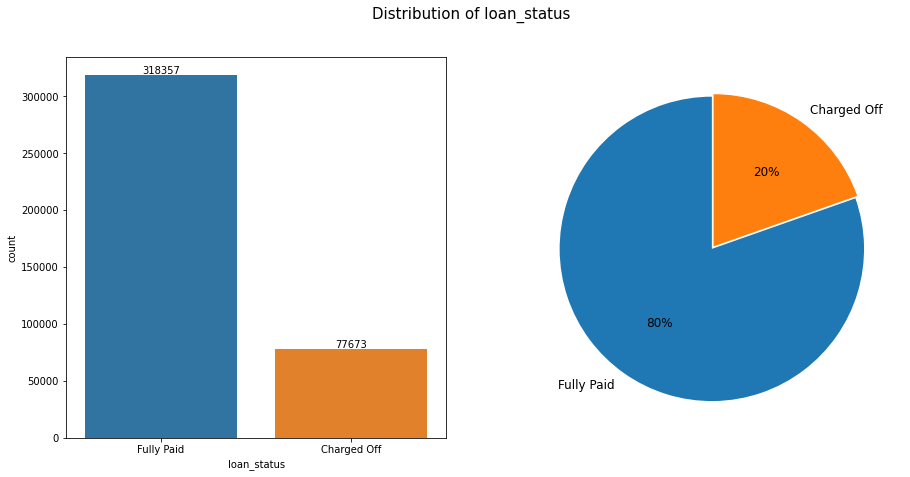

In [ ]:
make_categorical_plots(df, 'loan_status')

__Findings:__
- We have a skewed distribution of data
- 80% of customers pays their credit dues fully. 20% of the customers fails to complete their payment dues.

### Categorical Attributes

In [ ]:
df.select_dtypes('category').columns

Index(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'loan_status', 'purpose', 'initial_list_status', 'application_type',
       'pub_rec_bankruptcies'],
      dtype='object')

#### term

In [ ]:
df['term'].value_counts(normalize=True)*100

 36 months    76.258112
 60 months    23.741888
Name: term, dtype: float64

In [ ]:
df['term'].nunique()

2

__Findings:__
- The credit borrowings are made for either 36 months or 60 months

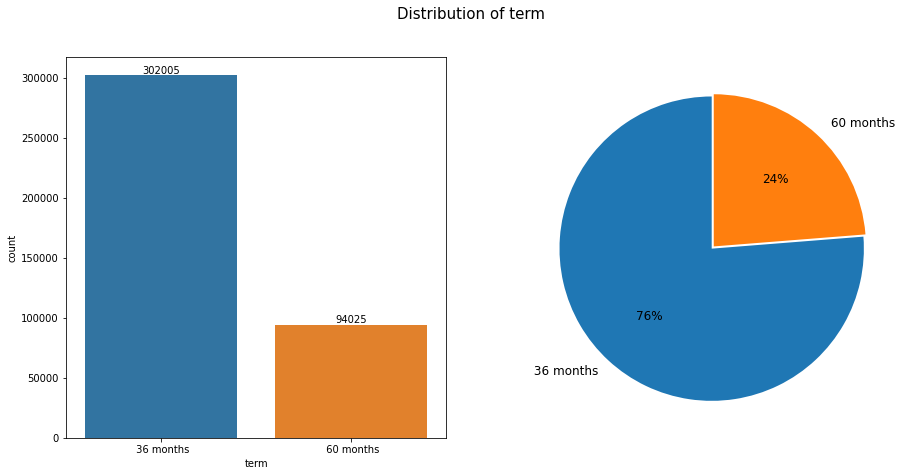

In [ ]:
make_categorical_plots(df, 'term')

__Findings:__
- 76% of the credit borrowings are made for 36 months
- 24% of the credit borrowings are made for 60 months

#### grade

In [ ]:
df['grade'].value_counts(normalize=True)*100

B    29.295255
C    26.762366
A    16.207611
D    16.040199
E     7.950913
F     2.972502
G     0.771154
Name: grade, dtype: float64

In [ ]:
df['grade'].nunique()

7

__Findings:__
- The Company assigns the loans into 7 grades: A, B, C, D, E, F, and G
- Most of the borrowers applies for loan grades B and C

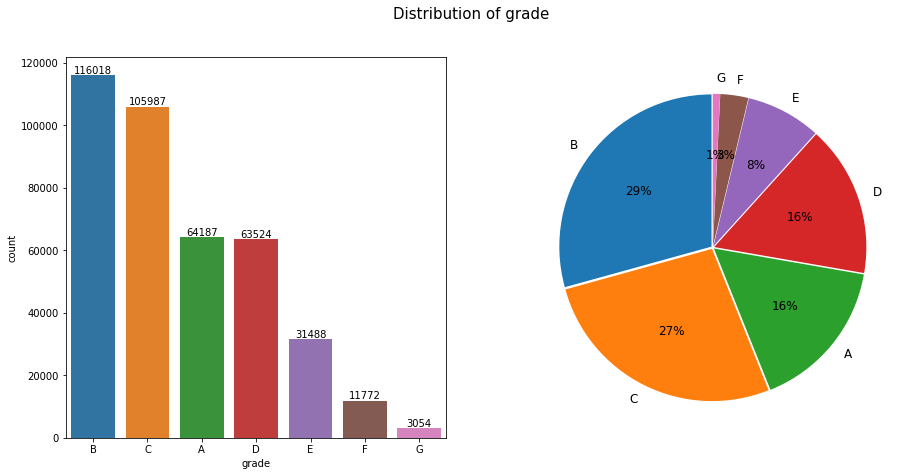

In [ ]:
make_categorical_plots(df, 'grade')

__Findings:__
- Most of the loan requests comes for loan grade B (29%), followed by loan grade C (27%). They account for around 56% of the loan requests 
- Loan requests for loan grades A and D are similar. They account for 32% of the loan requests
- Loan requests for the grades E, F, and G are very less. The account for only 12% of the total loan requests.

#### sub_grade

In [ ]:
df['sub_grade'].value_counts(normalize=True) * 100

B3    6.730551
B4    6.464409
C1    5.974800
C2    5.701588
B2    5.680125
B5    5.576598
C3    5.358432
C4    5.120824
B1    4.843572
A5    4.677928
C5    4.606722
D1    4.038330
A4    3.986819
D2    3.522713
D3    3.086382
D4    2.943464
A3    2.670505
A1    2.456632
D5    2.449309
A2    2.415726
E1    1.999091
E2    1.876373
E3    1.567306
E4    1.353685
E5    1.154458
F1    0.892862
F2    0.698432
F3    0.577229
F4    0.451228
F5    0.352751
G1    0.267151
G2    0.190390
G3    0.139383
G4    0.094437
G5    0.079792
Name: sub_grade, dtype: float64

In [ ]:
df['sub_grade'].nunique()

35

In [ ]:
df['sub_grade'].isnull().sum()

0

__Findings__
- There are 35 unique entries for loan subgrades

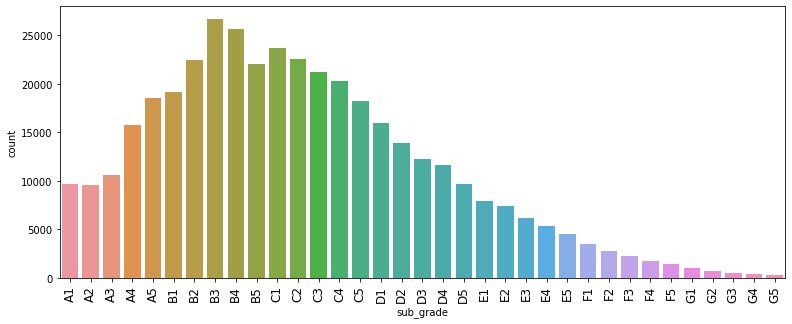

In [ ]:
# assigning a graph to each ax
feature = 'sub_grade'
data = df[feature].value_counts()
plt.figure(figsize=(13, 5))
ax = sns.countplot(data=df, x=feature, order=sorted(data.index))
if len(data) > 8:
    ax.set_xticklabels(labels=sorted(data.index), rotation=90, fontsize=12)
plt.show()

__Findings__
- The loan requests are high for sub grades B1 - B5 and C1 - C5.
- This behavior is expected from analysis of "grade"

#### emp_length

In [ ]:
df['emp_length'].value_counts(normalize=True)*100

10+ years    33.368103
2 years       9.484842
< 1 year      8.398879
3 years       8.382994
5 years       7.014288
1 year        6.852002
4 years       6.341054
6 years       5.517448
7 years       5.511623
8 years       5.074538
9 years       4.054229
Name: emp_length, dtype: float64

In [ ]:
df['emp_length'].nunique()

11

__Findings:__
- The loan applicants are categorized into 11 groups based on their duration of employment
- Most of the applicants are employed for more than 10+ years

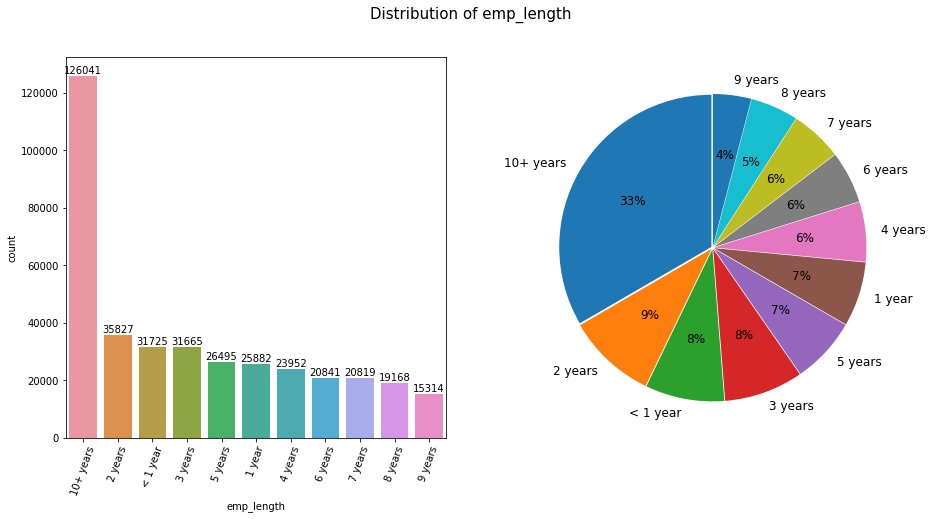

In [ ]:
make_categorical_plots(df, 'emp_length')

__Findings:__
- 33% of the loan applicants are employed for more than 10+ years
- Count of applicants with employment year between 0-9 are almost similar

#### home_ownership

In [ ]:
df['home_ownership'].value_counts(normalize=True)*100

MORTGAGE    50.084085
RENT        40.347953
OWN          9.531096
OTHER        0.028281
NONE         0.007828
ANY          0.000758
Name: home_ownership, dtype: float64

In [ ]:
df['home_ownership'].nunique()

6

__Findings:__
- There are 6 different indicators for the ownership status of loan applicants
- Most of borrowers have their property on mortgage or rent.

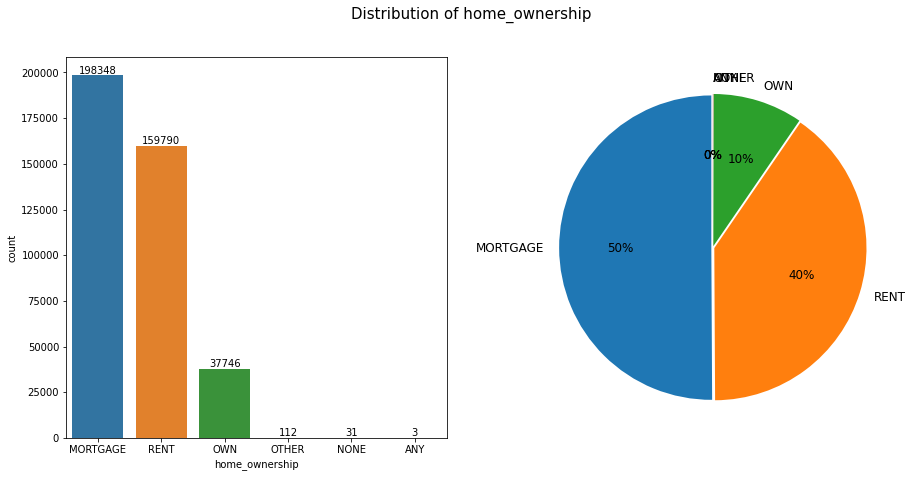

In [ ]:
make_categorical_plots(df, 'home_ownership')

__Findings:__
- Almost 90% of the loan applicants have their property on "MORTGAGE" or "RENT"
- Nearly ~9.5% of the applicants have their "OWN" property
- Very small percentage of applicants declared their property status as "OTHER", "NONE", or "ANY"

#### verification_status

In [ ]:
df['verification_status'].value_counts(normalize=True)*100

Verified           35.240512
Source Verified    33.175517
Not Verified       31.583971
Name: verification_status, dtype: float64

In [ ]:
df['verification_status'].nunique()

3

__Findings:__
- There are 3 different indicators for the income status of the applicants: income was verified by the Company, not verified, or if the income source was verified
- Nearly equal number of applications comes from each group

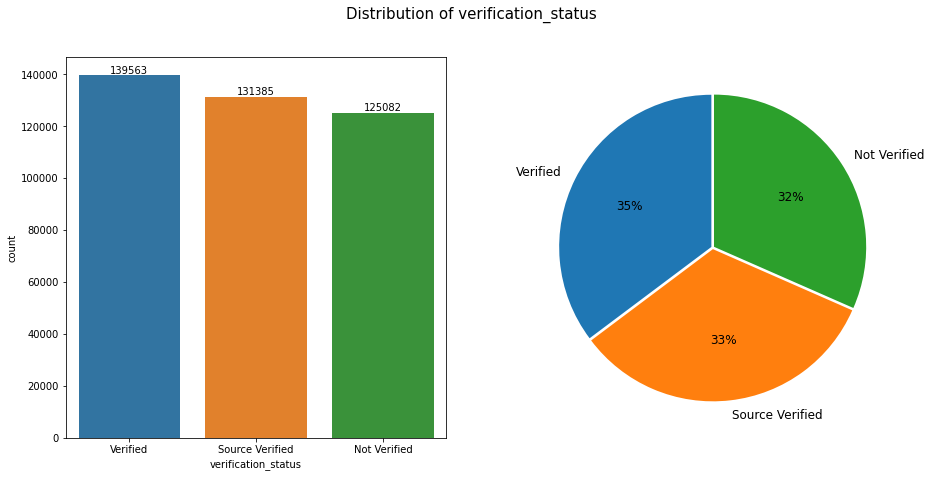

In [ ]:
make_categorical_plots(df, 'verification_status')

__Findings:__
- 35% of the applicants have their income verified by the Company
- 32% of the applicants do not have their income verified by the Company
- 33% of the applicants have their income source verified

#### purpose

In [ ]:
df['purpose'].value_counts(normalize=True)*100

debt_consolidation    59.214453
credit_card           20.962806
home_improvement       6.067722
other                  5.349342
major_purchase         2.219529
small_business         1.439537
car                    1.186021
medical                1.059516
moving                 0.720652
vacation               0.619145
house                  0.555766
wedding                0.457541
renewable_energy       0.083075
educational            0.064894
Name: purpose, dtype: float64

In [ ]:
df['purpose'].nunique()

14

__Findings:__
- 14 different types of loan requests can be made by the customers
- Most of the loan requests are made for the purposes "debt_consolidation" and "credit_card".

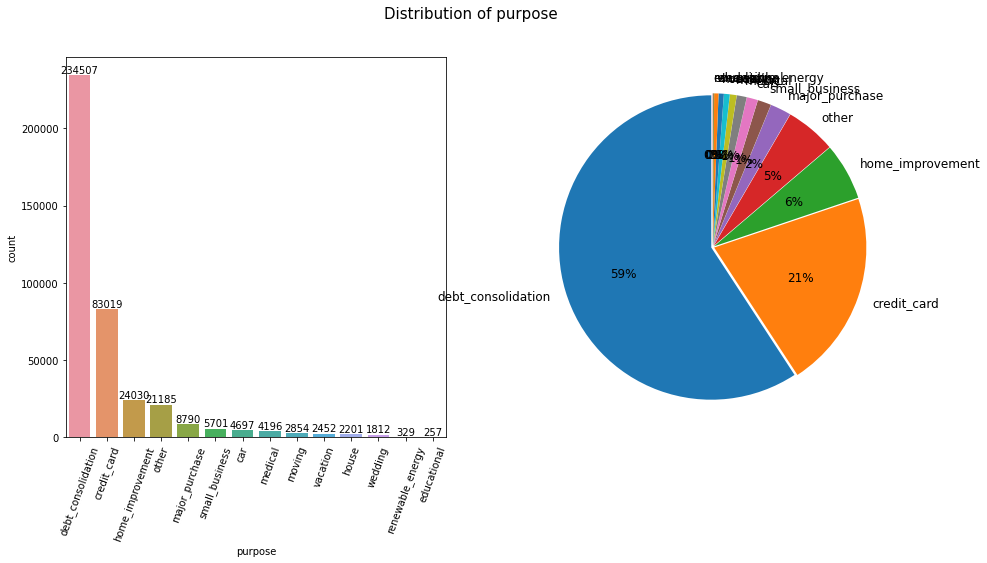

In [ ]:
make_categorical_plots(df, 'purpose')

__Findings:__
- Around 80% of the loan applications are for the purposes "debt_consolidation" and "credit_card".
- The other 12 purposes only account for 20% of the total loan applications.

#### initial_list_status

In [ ]:
df['initial_list_status'].value_counts(normalize=True)*100

f    60.113123
w    39.886877
Name: initial_list_status, dtype: float64

In [ ]:
df['initial_list_status'].nunique()

2

__Findings:__
- The initial loan status of the customers are indicated using two values: "f" and "w"

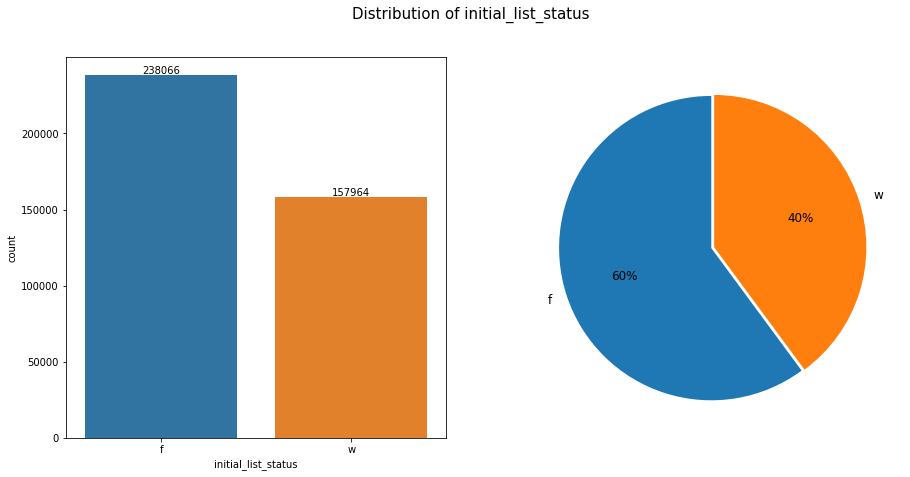

In [ ]:
make_categorical_plots(df, 'initial_list_status')

__Findings:__
- 60% of the loan applications are labelled "f"
- 40% of the loan applications are labelled "w"

#### application_type

In [ ]:
df['application_type'].value_counts(normalize=True)*100

INDIVIDUAL    99.820468
JOINT          0.107315
DIRECT_PAY     0.072217
Name: application_type, dtype: float64

In [ ]:
df['application_type'].nunique()

3

__Findings:__
- There are 3 types of loan applicants: INDIVIDUAL, JOINT, and DIRECT_PAY
- Most of the loan applications are made by INDIVIDUALs

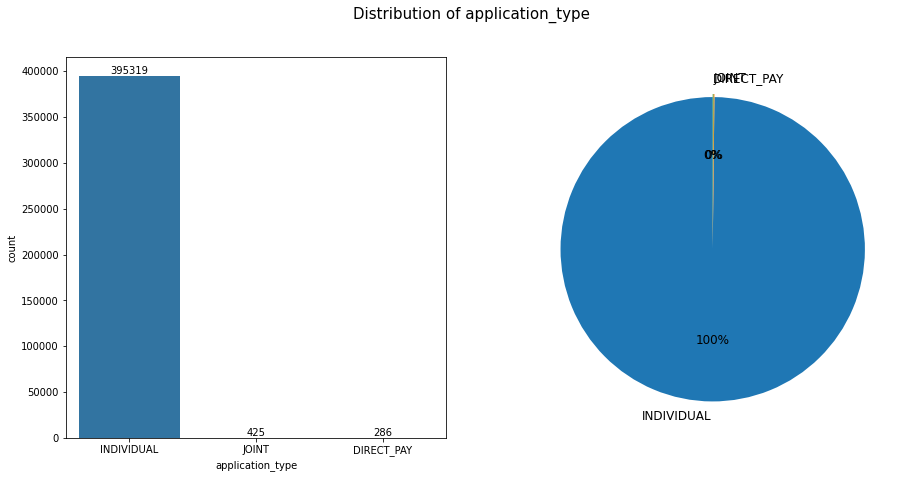

In [ ]:
make_categorical_plots(df, 'application_type')

__Findings:__
- Around 99.8% of the loan applications are by individuals.
- The other applicants only account of 0.2% of the total loan applications.
- One of the categories is highly dominating here, implying low variance. This feature will be less useful for modelling purpose.

#### pub_rec_bankruptcies

In [ ]:
df['pub_rec_bankruptcies'].value_counts(normalize=True)*100

0.0    88.592776
1.0    10.819353
2.0     0.467010
3.0     0.088750
4.0     0.020734
5.0     0.008091
6.0     0.001770
7.0     0.001011
8.0     0.000506
Name: pub_rec_bankruptcies, dtype: float64

In [ ]:
df['pub_rec_bankruptcies'].nunique()

9

__Findings:__
- This attribute gives the number of public record bankruptcies by a customer
- The customers public record bankruptcy counts ranges from 0 to 8

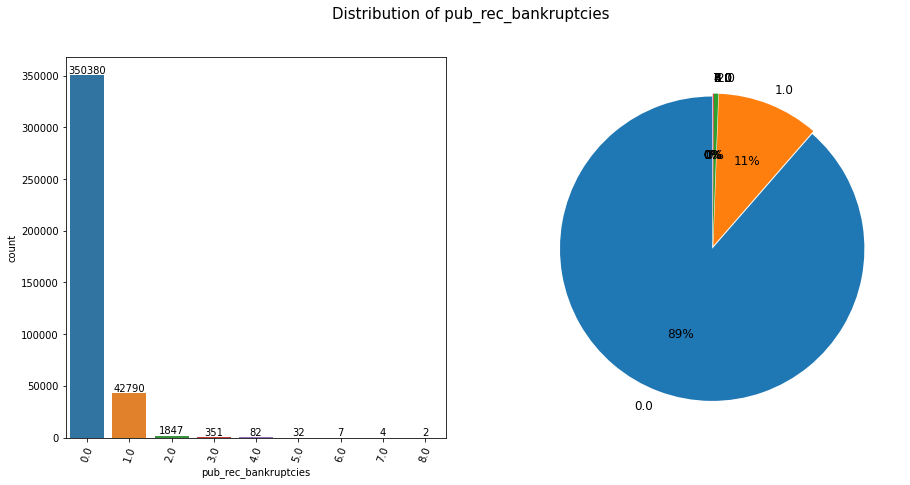

In [ ]:
make_categorical_plots(df, 'pub_rec_bankruptcies')

__Findings:__
- Around 88% of the customers have no public record bankruptcies
- ~11% of the customers have 1 public record bankruptcy. 
- Only around ~1% of customers have 2 or more bankruptcies

### Numerical Attributes

In [ ]:
def make_numerical_plots(df, feature, bins='auto'):
    """
    Method to make univariate numerical plot
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(df[feature], ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist, kde=True, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

def bi_cat_plot(df, x, target="loan_status"):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

In [ ]:
df.select_dtypes('number').columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc'],
      dtype='object')

#### loan_amnt

In [ ]:
df['loan_amnt'].describe()

count    396030.000000
mean      14113.888089
std        8357.441341
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

__Findings:__
- The loan amount applied for by a borrower can range from 500 to 40000
- On an average, the loan amount request by a borrow is 14113. The median loan request amount is 12000

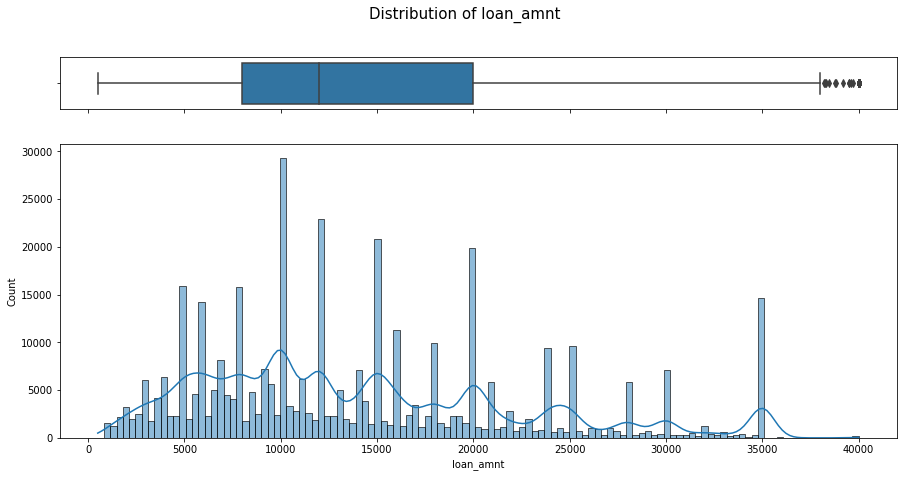

In [ ]:
make_numerical_plots(df, 'loan_amnt')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["loan_amnt"])} are considered outliers')
print(f'There are {outlier_count(df["loan_amnt"])} outlier data points')

The values lying ouside of (-10000.0, 38000.0) are considered outliers
There are 191 outlier data points


In [ ]:
191 / df.shape[0] * 100

0.04822866954523647

__Findings:__
- There are only ~0.04% of outliers. We can safely remove these rows.

#### int_rate

In [ ]:
df['int_rate'].describe()

count    396030.000000
mean         13.639400
std           4.472157
min           5.320000
25%          10.490000
50%          13.330000
75%          16.490000
max          30.990000
Name: int_rate, dtype: float64

__Findings:__
- The Interest Rate on the loan can range from 5.3 to 30.9
- On an average, the interest rate is 13.6 . The median interest rate is 13.3

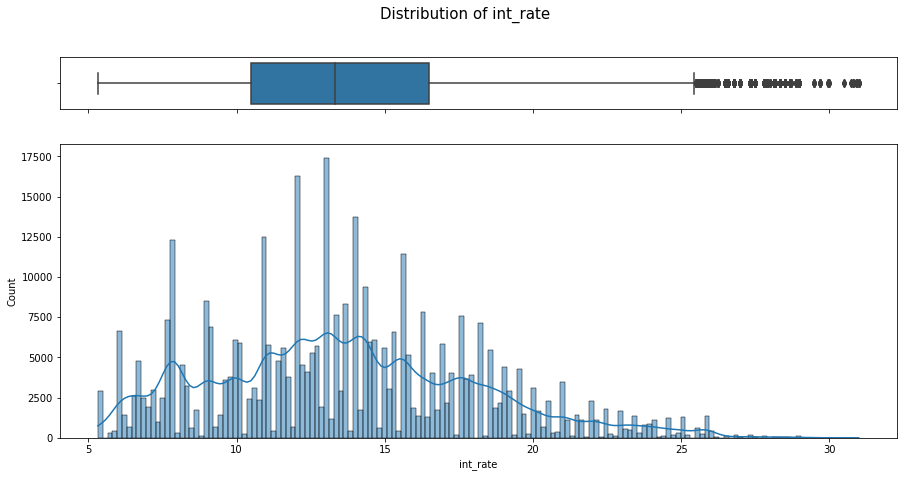

In [ ]:
make_numerical_plots(df, 'int_rate')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["int_rate"])} are considered outliers')
print(f'There are {outlier_count(df["int_rate"])} outlier data points')

The values lying ouside of (1.4900000000000038, 25.489999999999995) are considered outliers
There are 3777 outlier data points


In [ ]:
3777 / df.shape[0] * 100

0.9537156276039694

__Findings:__
- There are only ~1% of outliers in the data. We can safely remove these rows.

#### installment

In [ ]:
df['installment'].describe()

count    396030.000000
mean        431.849698
std         250.727790
min          16.080000
25%         250.330000
50%         375.430000
75%         567.300000
max        1533.810000
Name: installment, dtype: float64

__Findings:__
- The monthly payment owed by the borrowers can range from 16 to ~1534
- On an average, a borrower has a monthly due of ~432. The median due is 375

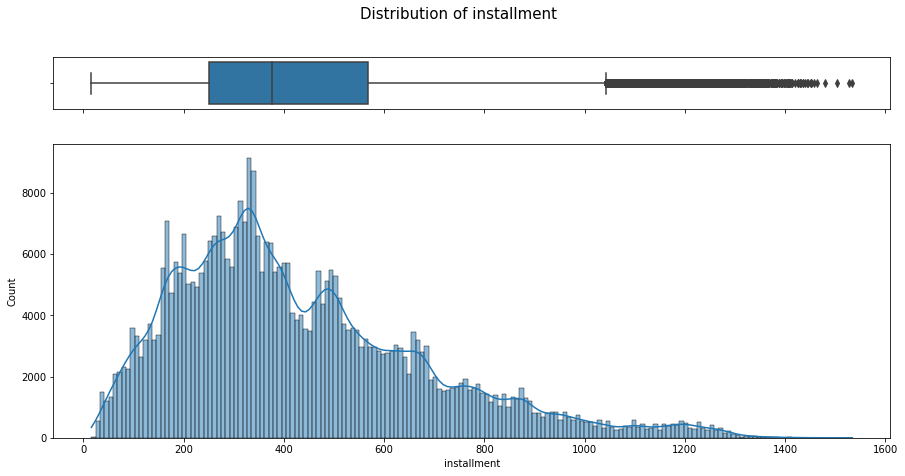

In [ ]:
make_numerical_plots(df, 'installment')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["installment"])} are considered outliers')
print(f'There are {outlier_count(df["installment"])} outlier data points')

The values lying ouside of (-225.12499999999986, 1042.7549999999999) are considered outliers
There are 11250 outlier data points


In [ ]:
11250 / df.shape[0] * 100

2.8406938868267555

__Findings:__
- There are only ~3% of outliers in the data. We can safely remove these rows.

#### annual_inc

In [ ]:
df['annual_inc'].describe()

count    3.960300e+05
mean     7.420318e+04
std      6.163762e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

__Findings:__
- The annual income of the borrowers can range from 0 to 8706582
- The average annual income of a borrower is 74203. The median annual income is 64000

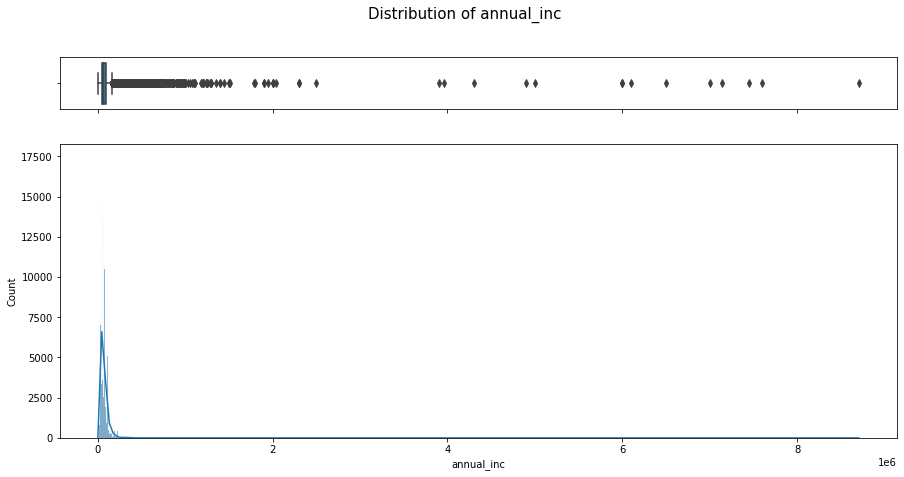

In [ ]:
make_numerical_plots(df, 'annual_inc')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["annual_inc"])} are considered outliers')
print(f'There are {outlier_count(df["annual_inc"])} outlier data points')

The values lying ouside of (-22500.0, 157500.0) are considered outliers
There are 16700 outlier data points


In [ ]:
16700 / df.shape[0] * 100

4.216852258667273

__Findings__
- Around 4% of the data are outliers. We can safely remove these rows

#### dti

In [ ]:
df['dti'].describe()

count    396030.000000
mean         17.379514
std          18.019092
min           0.000000
25%          11.280000
50%          16.910000
75%          22.980000
max        9999.000000
Name: dti, dtype: float64

__Findings:__
- The dti ratio of the borrowers can range from 0 to 86
- The average dti ratio of a borrower is 17. The median value is also ~17.

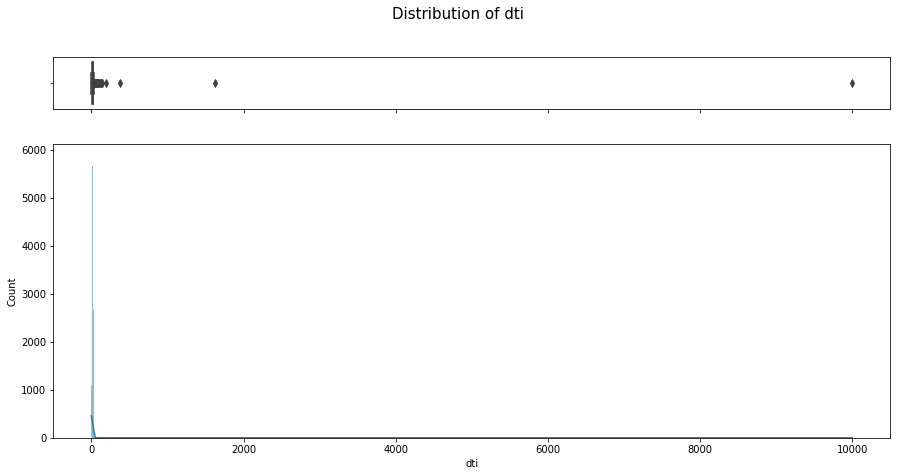

In [ ]:
make_numerical_plots(df, 'dti')

__Findings:__
- There are few outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["dti"])} are considered outliers')
print(f'There are {outlier_count(df["dti"])} outlier data points')

The values lying ouside of (-6.270000000000001, 40.53) are considered outliers
There are 275 outlier data points


In [ ]:
275 / df.shape[0] * 100

0.06943918390020958

__Findings:__
- There are only ~0.06% of outliers in the data. We can safely remove these rows.

#### open_acc

In [ ]:
df['open_acc'].describe()

count    396030.000000
mean         11.311153
std           5.137649
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64

__Findings:__
- The number of open credit lines in the borrower's credit file can range from 0 to 90
- On an average, a borrower has 11 open credit lines. The median value is also 10

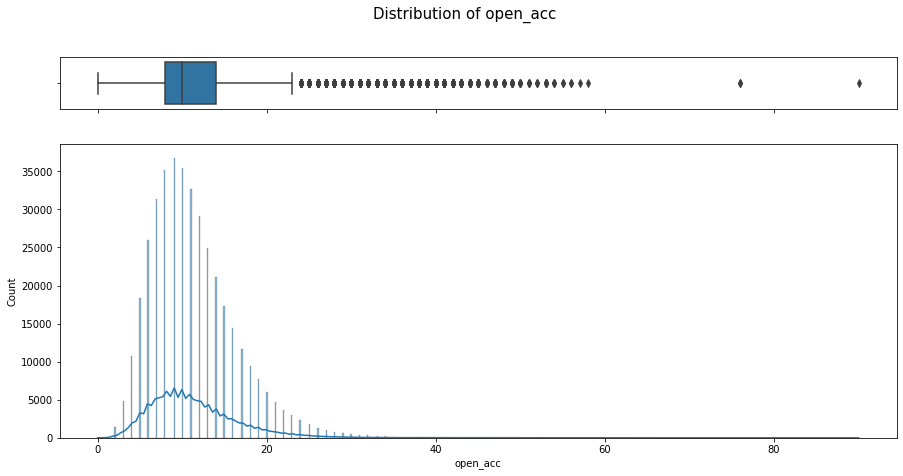

In [ ]:
make_numerical_plots(df, 'open_acc')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["open_acc"])} are considered outliers')
print(f'There are {outlier_count(df["open_acc"])} outlier data points')

The values lying ouside of (-1.0, 23.0) are considered outliers
There are 10307 outlier data points


In [ ]:
10307 / df.shape[0] * 100

2.602580612579855

__Findings:__
- There are only ~2% of outliers. We can safely remove these rows.

#### pub_rec

In [ ]:
df['pub_rec'].describe()

count    396030.000000
mean          0.178191
std           0.530671
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

__Findings:__
- The Number of derogatory public records of the borrowers can range from 0 to 86
- On an average, a borrower has 0 derogatory public records. The median value is also 0

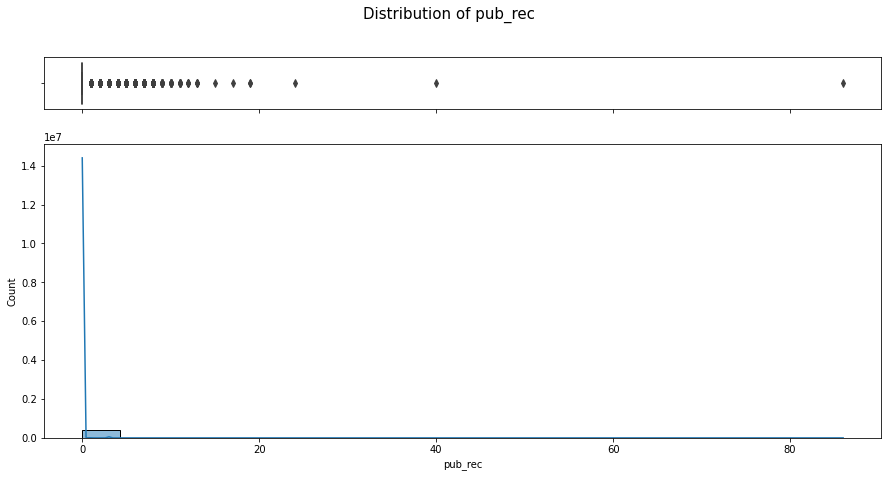

In [ ]:
make_numerical_plots(df, 'pub_rec')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["pub_rec"])} are considered outliers')
print(f'There are {outlier_count(df["pub_rec"])} outlier data points')

The values lying ouside of (0.0, 0.0) are considered outliers
There are 57758 outlier data points


In [ ]:
57758 / df.shape[0] * 100

14.5842486680302

__15%!!! Thats too many outliers. Removing them might affect our analysis.__

Instead of IQR, we can use Z-score to check for outliers.

In [ ]:
col = 'pub_rec'
z_scores_pub_rec = (df[col] - df[col].mean()) / df[col].std(ddof=0)

We can remove the rows with z-score less than 3.

In [ ]:
cleaned_pub_rec = (z_scores_pub_rec < 3).sum()
noise = len(z_scores_pub_rec) - cleaned_pub_rec
print(f'Total outliers detected using Z-score method = {noise}, {noise/len(z_scores_pub_rec)*100}%')

Total outliers detected using Z-score method = 8019, 2.0248466025301113%


__Findings:__
- There are only ~2% of outliers using the Z-score method. We can safely remove these rows.

#### revol_bal

In [ ]:
df['revol_bal'].describe()

count    3.960300e+05
mean     1.584454e+04
std      2.059184e+04
min      0.000000e+00
25%      6.025000e+03
50%      1.118100e+04
75%      1.962000e+04
max      1.743266e+06
Name: revol_bal, dtype: float64

__Findings:__
- The Total credit revolving balance of the borrowers can range from 0 to 1743266
- The average revolving balance ~15844. The median value is ~11181

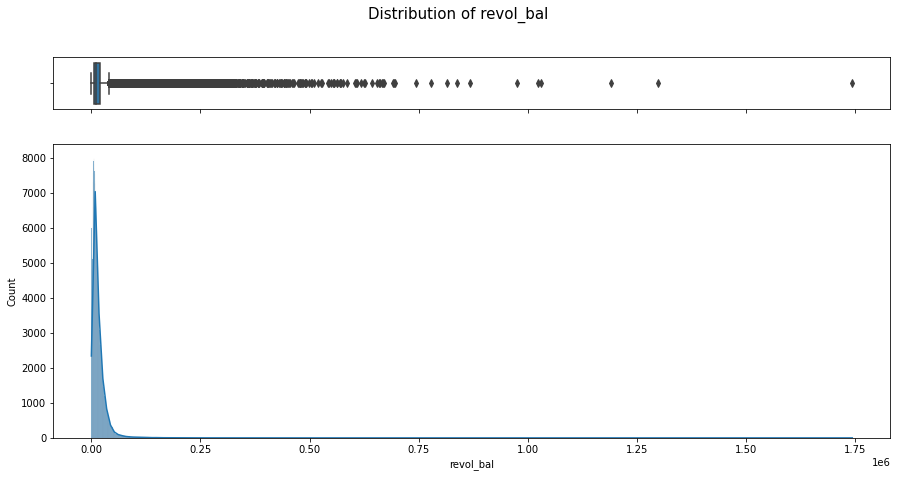

In [ ]:
make_numerical_plots(df, 'revol_bal')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["revol_bal"])} are considered outliers')
print(f'There are {outlier_count(df["revol_bal"])} outlier data points')

The values lying ouside of (-14367.5, 40012.5) are considered outliers
There are 21259 outlier data points


In [ ]:
21259 / df.shape[0] * 100

5.368027674671111

__Findings:__
- Around 5% of the data are outliers.

In [ ]:
def bi_cat_plot(df, x, target="loan_status"):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

In [ ]:
df.groupby('loan_status')['revol_bal'].describe()

count          mean           std  min     25%      50%  \
loan_status                                                               
Charged Off   77673.0  15390.454701  18203.387930  0.0  6150.0  11277.0   
Fully Paid   318357.0  15955.327918  21132.193457  0.0  5992.0  11158.0   

                 75%        max  
loan_status                      
Charged Off  19485.0  1030826.0  
Fully Paid   19657.0  1743266.0

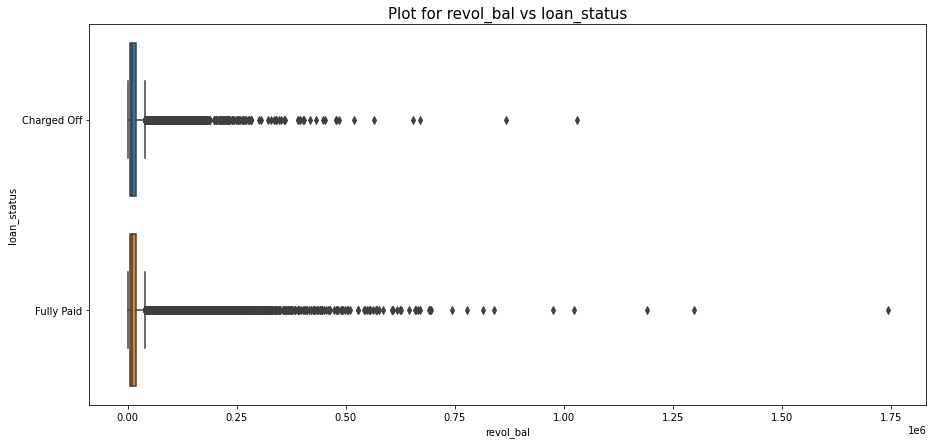

In [ ]:
bi_cat_plot(df, 'revol_bal')

__Findings:__
- There is no as such correlation between "revol_bal" and "loan_status"
- We can remove these outliers safely

#### revol_util

In [ ]:
df['revol_util'].describe()

count    395754.000000
mean         53.791749
std          24.452193
min           0.000000
25%          35.800000
50%          54.800000
75%          72.900000
max         892.300000
Name: revol_util, dtype: float64

__Findings:__
- The revolving line utilization rate of the borrowers ranges from 0 to 892
- The average revolving line utilization rate is ~54. Median value is ~51

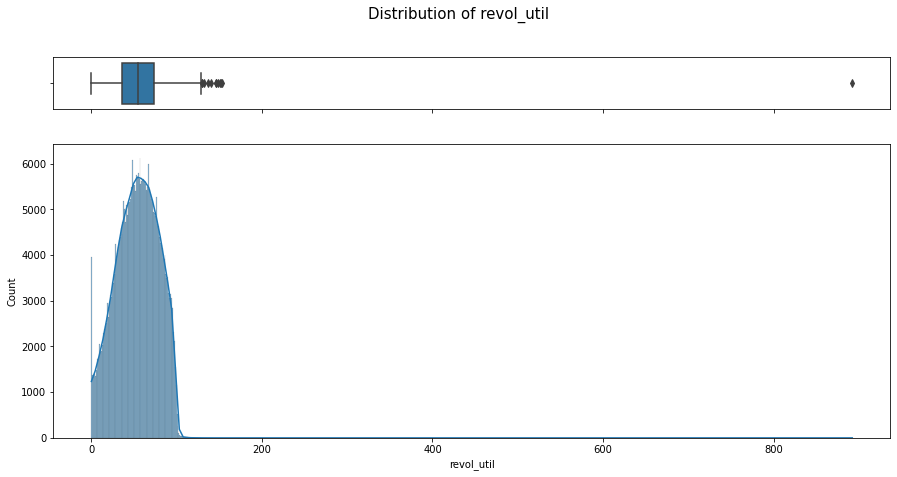

In [ ]:
make_numerical_plots(df, 'revol_util')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["revol_util"])} are considered outliers')
print(f'There are {outlier_count(df["revol_util"])} outlier data points')

The values lying ouside of (-19.850000000000016, 128.55) are considered outliers
There are 12 outlier data points


In [ ]:
12 / df.shape[0] * 100

0.0030300734792818723

__Findings:__
- Only ~0.003 percent of the total data are outliers. We can safely remove them 

#### total_acc

In [ ]:
df['total_acc'].describe()

count    396030.000000
mean         25.414744
std          11.886991
min           2.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         151.000000
Name: total_acc, dtype: float64

__Findings:__
- The number of credit lines currently in the borrower's credit files can range from 2 to 151
- The applicants have ~25 credit lines on average. Median value is 24

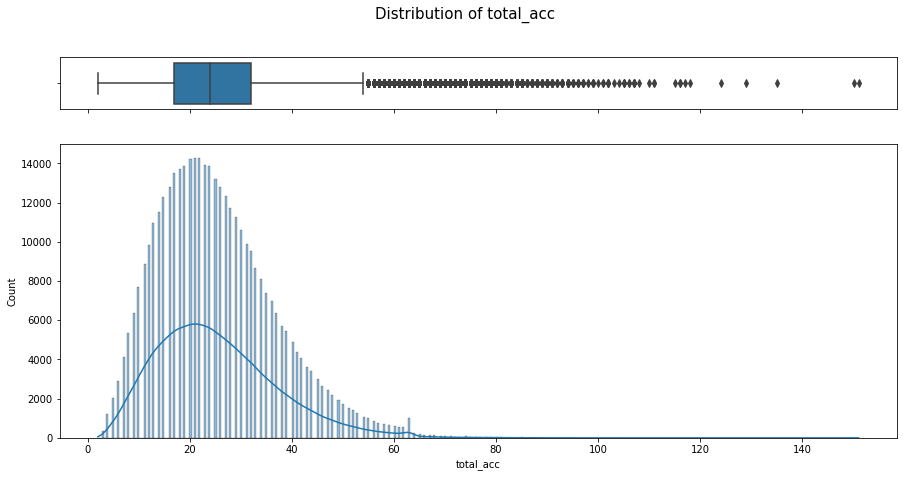

In [ ]:
make_numerical_plots(df, 'total_acc')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["total_acc"])} are considered outliers')
print(f'There are {outlier_count(df["total_acc"])} outlier data points')

The values lying ouside of (-5.5, 54.5) are considered outliers
There are 8499 outlier data points


In [ ]:
8499 / df.shape[0] * 100

2.1460495417013865

__Findings:__
- Only ~2 percent of the total data are outliers. We can safely remove them 

#### mort_acc

In [ ]:
df['mort_acc'].describe()

count    358235.000000
mean          1.813991
std           2.147930
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          34.000000
Name: mort_acc, dtype: float64

__Findings:__
- The number of mortgage accounts of an applicant can range from 0 to 34
- The applicants have ~2 mortgage accounts on average. Median value is 1

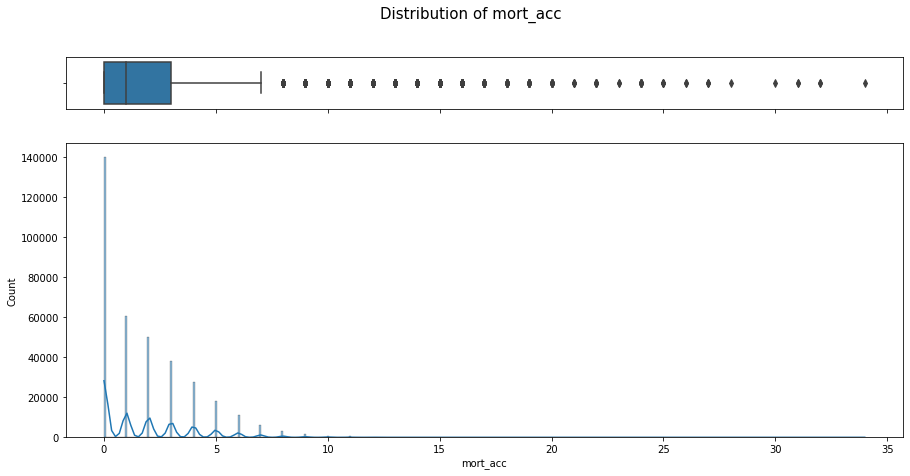

In [ ]:
make_numerical_plots(df, 'mort_acc')

__Findings:__
- There are outliers values

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["mort_acc"])} are considered outliers')
print(f'There are {outlier_count(df["mort_acc"])} outlier data points')

The values lying ouside of (-4.5, 7.5) are considered outliers
There are 6843 outlier data points


In [ ]:
6843 / df.shape[0] * 100

1.7278994015604878

__Findings:__
- Only 1.7 percent of the total data are outliers. We can safely remove them 

### Object Attributes

In [ ]:
object_cols = ['address', 'earliest_cr_line', 'emp_title', 'issue_d', 'title']
df[object_cols].head()

address earliest_cr_line  \
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690         Jun-1990   
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113         Jul-2004   
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113         Aug-2007   
3            823 Reid Ford\r\nDelacruzside, MA 00813         Sep-2006   
4             679 Luna Roads\r\nGreggshire, VA 11650         Mar-1999   

                 emp_title   issue_d                    title  
0                Marketing  Jan-2015                 Vacation  
1          Credit analyst   Jan-2015       Debt consolidation  
2             Statistician  Jan-2015  Credit card refinancing  
3          Client Advocate  Nov-2014  Credit card refinancing  
4  Destiny Management Inc.  Apr-2013    Credit Card Refinance

#### emp_title

In [ ]:
df['emp_title'].value_counts()

Teacher                    4389
Manager                    4250
Registered Nurse           1856
RN                         1846
Supervisor                 1830
                           ... 
Postman                       1
McCarthy & Holthus, LLC       1
jp flooring                   1
Histology Technologist        1
Gracon Services, Inc          1
Name: emp_title, Length: 173105, dtype: int64

In [ ]:
df['emp_title'].nunique()

173105

In [ ]:
df['emp_title'].isnull().sum()

22927

__Findings__
- There are 173105 unique entries for "emp_title"
- There are 22927 missing values
- "Teacher", "Manager", and "Registered Nurse" are the top 3 borrowers of loan


#### title

In [ ]:
df['title'].value_counts()

Debt consolidation            152472
Credit card refinancing        51487
Home improvement               15264
Other                          12930
Debt Consolidation             11608
                               ...  
Graduation/Travel Expenses         1
Daughter's Wedding Bill            1
gotta move                         1
creditcardrefi                     1
Toxic Debt Payoff                  1
Name: title, Length: 48817, dtype: int64

In [ ]:
df['title'].nunique()

48817

In [ ]:
df['title'].isnull().sum()

1755

__Findings__
- There are 48817 unique entries for loan title
- There are 22927 missing values
- Most the loan requests are for "Debt consolidation" and "Credit card refinancing"


#### issue_d

In [ ]:
df['issue_d'].value_counts()

Oct-2014    14846
Jul-2014    12609
Jan-2015    11705
Dec-2013    10618
Nov-2013    10496
            ...  
Jul-2007       26
Sep-2008       25
Nov-2007       22
Sep-2007       15
Jun-2007        1
Name: issue_d, Length: 115, dtype: int64

In [ ]:
df['issue_d'].nunique()

115

In [ ]:
df['issue_d'].isnull().sum()

0

__Findings__
- There are 115 unique entries for issue month


In [ ]:
def extract_year_month(x, type):
    year_month = x.split('-')
    if type == 'year':
        return year_month[1]
    elif type=='month':
        return year_month[0]

In [ ]:
df['year'] = df['issue_d'].apply(lambda x: extract_year_month(x, 'year'))
df['month'] = df['issue_d'].apply(lambda x: extract_year_month(x, 'month'))
df[['month', 'year']]

month  year
0        Jan  2015
1        Jan  2015
2        Jan  2015
3        Nov  2014
4        Apr  2013
...      ...   ...
396025   Oct  2015
396026   Feb  2015
396027   Oct  2013
396028   Aug  2012
396029   Jun  2010

[396030 rows x 2 columns]

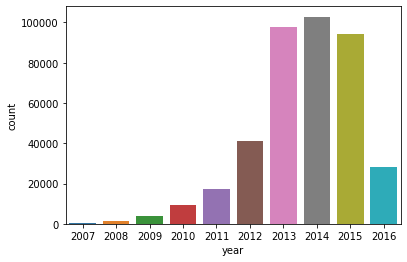

In [ ]:
# assigning a graph to each ax
feature = 'year'
data = df[feature].value_counts()
sns.countplot(data=df, x=feature, order=sorted(data.index))
plt.show()

__Findings__
- We have data from 2007-2016
- There is an exponential increase in the loan grants from 2007 to 2014
- There has been a decrease in the loan grants from 2015 to 2016

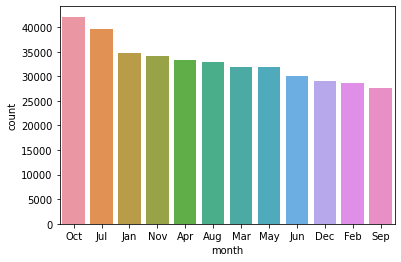

In [ ]:
# assigning a graph to each ax
feature = 'month'
data = df[feature].value_counts()
sns.countplot(data=df, x=feature, order=data.index)
plt.show()

__Findings__
- Most of the loans are funded in October, followed by July and January
- The loans are funded the lowest in December, February, and September

#### earliest_cr_line

In [ ]:
df['earliest_cr_line'].value_counts()

Oct-2000    3017
Aug-2000    2935
Oct-2001    2896
Aug-2001    2884
Nov-2000    2736
            ... 
Jul-1958       1
Nov-1957       1
Jan-1953       1
Jul-1955       1
Aug-1959       1
Name: earliest_cr_line, Length: 684, dtype: int64

In [ ]:
df['earliest_cr_line'].nunique()

684

In [ ]:
df['earliest_cr_line'].isnull().sum()

0

__Findings__
- There are 684 unique entries for borrower's earliest reported credit line 


In [ ]:
def extract_year_month(x, type):
    year_month = x.split('-')
    if type == 'year':
        return year_month[1]
    elif type=='month':
        return year_month[0]

In [ ]:
df['year_cr'] = df['earliest_cr_line'].apply(lambda x: extract_year_month(x, 'year'))
df['month_cr'] = df['earliest_cr_line'].apply(lambda x: extract_year_month(x, 'month'))
df[['month_cr', 'year_cr']]

month_cr year_cr
0           Jun    1990
1           Jul    2004
2           Aug    2007
3           Sep    2006
4           Mar    1999
...         ...     ...
396025      Nov    2004
396026      Feb    2006
396027      Mar    1997
396028      Nov    1990
396029      Sep    1998

[396030 rows x 2 columns]

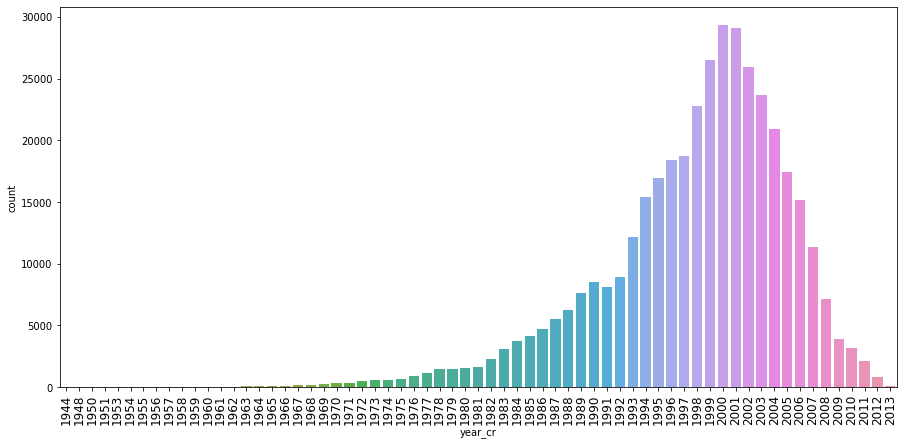

In [ ]:
# assigning a graph to each ax
feature = 'year_cr'
data = df[feature].value_counts()
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=df, x=feature, order=sorted(data.index))
if len(data) > 8:
    ax.set_xticklabels(labels=sorted(data.index), rotation=90, fontsize=12)
plt.show()

__Findings__
- The borrower's earliest reported credit line range from 1944 to 2013
- There is an exponential increase in the opening of credit line from 1944 to 2000
- There has been a decrease in the opening of credit line from 2001 to 2013

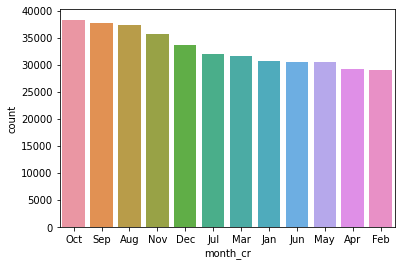

In [ ]:
# assigning a graph to each ax
feature = 'month_cr'
data = df[feature].value_counts()
sns.countplot(data=df, x=feature, order=data.index)
plt.show()

__Findings__
- Most of the credit lines are opened in October, followed by September and August
- The opening of credit lines are lowest in May, April, and February

#### address

In [ ]:
df['address'].value_counts()

USCGC Smith\r\nFPO AE 70466                           8
USS Johnson\r\nFPO AE 48052                           8
USNS Johnson\r\nFPO AE 05113                          8
USS Smith\r\nFPO AP 70466                             8
USNS Johnson\r\nFPO AP 48052                          7
                                                     ..
455 Tricia Cove\r\nAustinbury, FL 00813               1
7776 Flores Fall\r\nFernandezshire, UT 05113          1
6577 Mia Harbors Apt. 171\r\nRobertshire, OK 22690    1
8141 Cox Greens Suite 186\r\nMadisonstad, VT 05113    1
787 Michelle Causeway\r\nBriannaton, AR 48052         1
Name: address, Length: 393700, dtype: int64

In [ ]:
df['address'].nunique()

393700

In [ ]:
df['address'].isnull().sum()

0

__Findings__
- There are 393700 unique entries for "address", ie. the address is unique to almost all the entries
- This feature won't be useful for modelling purposes.


__Extracting the states from each address:__

In [ ]:
def extract_states(x):
    return x.split()[-2]

In [ ]:
df['states'] = df['address'].apply(extract_states)
df['states'] 

0         OK
1         SD
2         WV
3         MA
4         VA
          ..
396025    DC
396026    LA
396027    NY
396028    FL
396029    AR
Name: states, Length: 396030, dtype: object

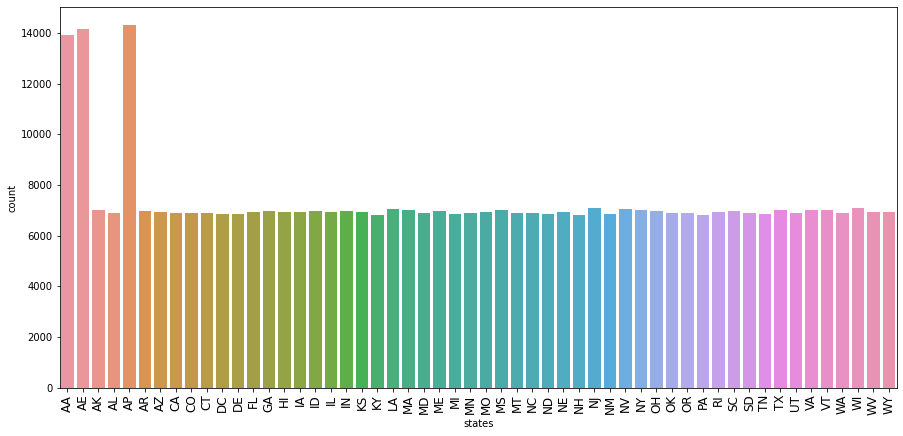

In [ ]:
# assigning a graph to each ax
feature = 'states'
data = df[feature].value_counts()
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=df, x=feature, order=sorted(data.index))
if len(data) > 8:
    ax.set_xticklabels(labels=sorted(data.index), rotation=90, fontsize=12)
plt.show()

__Findings__
- The loan requests for all the states except "AA", "AE", and "AP" are almost similar.

## Cleaning the data

Before we move to bivariate analysis, we will remove the outliers, and any unwanted columns:

Following steps are done for cleaning:
- removing zero variance columns (columns where one of the category is highly dominating)
- removing outliers using IQR method from numerical columns
- removing outliers using Z-score method from numerical columns
- dropping the columns that are not useful for modelling (the object columns like "emp_title", "title", "issue_d", "earliest_cr_line", and "address")
- dropping the temporary columns that were created for analysis ("month", "year", "month_cr", and "year_cr")

In [ ]:
def clean_data(df, iqr_cols, zscore_cols, zero_variance_cols, unwanted_cols, temp_cols):

    # 0 --> get ranges
    fence_dict = {}
    zscores_dict = {}

    for col in iqr_cols:
        fence_dict[col] = quantile_boundaries(df[col])
    
    for col in zscore_cols:
        zscores_dict[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    # 1 --> remove using Z-score
    for col in zscore_cols:
        df = df[zscores_dict[col] < 3]

    print(df.shape)

    # 2 --> remove using IQR
    for col in iqr_cols:
        low, high = fence_dict[col]
        df = df[(df[col]>=low) & (df[col]<=high)]

    print(df.shape)


    # 3 --> remove zero variance cols
    df = df.drop(columns = zero_variance_cols)

    # 4 --> remove unwanted cols
    df = df.drop(columns = unwanted_cols)

    # 5 --> remove temp cols
    df = df.drop(columns = temp_cols)

    return df

In [ ]:
iqr_cols           = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',  \
                      'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']
zscore_cols        = ['pub_rec']

zero_variance_cols = ['application_type']
unwanted_cols      = ['emp_title', 'title', 'issue_d', 'earliest_cr_line', 'address']
temp_cols          = ['month', 'year', 'month_cr', 'year_cr']


cleaned_df = clean_data(df, iqr_cols, zscore_cols, zero_variance_cols, unwanted_cols, temp_cols)
cleaned_df.shape

(388011, 32)
(294953, 32)


(294953, 22)

In [ ]:
print(f'Percentage of rows removed = {(len(df) - len(cleaned_df)) / len(df) * 100}')

Percentage of rows removed = 25.522561422114485


## Bivariate Analysis

The dependent variable for our problem statement is "loan_status", and the remaing attribues are the independent variable. We will try to determine if credit line should extended to a business given a set of attributes for an MSME/ Individual.

### Numericals

In [ ]:
num_cols = cleaned_df.select_dtypes('number').columns
num_cols

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc'],
      dtype='object')

In [ ]:
def bi_cat_plot(df, x, target="loan_status"):
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df, x=target, y=x)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)

#### Effect of loan_amt on loan_status

In [ ]:
target = 'loan_status'
col    = 'loan_amnt'

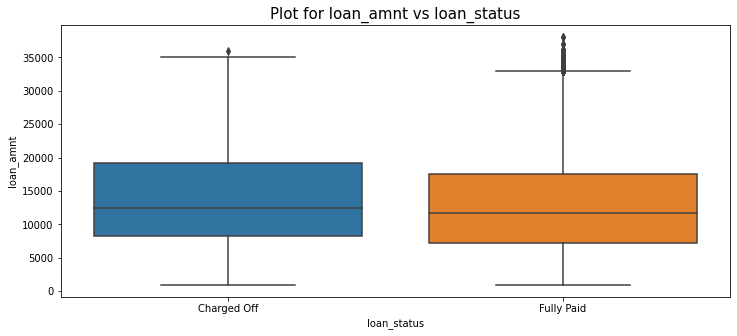

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    14095.661527
Fully Paid     12863.538957
Name: loan_amnt, dtype: float64

__Findings__:

- The borrowers who are charged off apply for a higher amount of loan, as compared to those who pay off their loans.

#### Effect of int_rate on loan_status

In [ ]:
target = 'loan_status'
col    = 'int_rate'

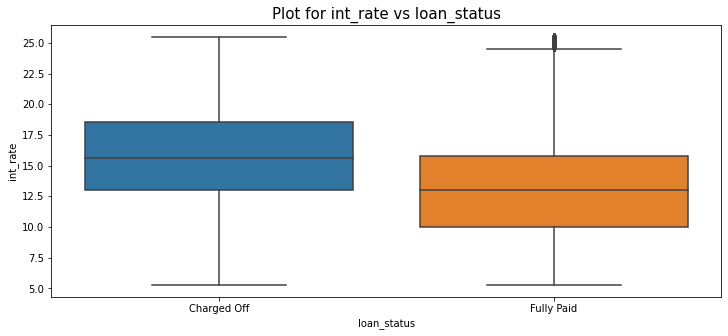

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    15.750780
Fully Paid     13.145822
Name: int_rate, dtype: float64

__Findings__:

- The borrowers who are charged off takes loans at a higher interest rate, as compared to those who pay off their loans.

#### Effect of installment on loan_status

In [ ]:
target = 'loan_status'
col    = 'installment'

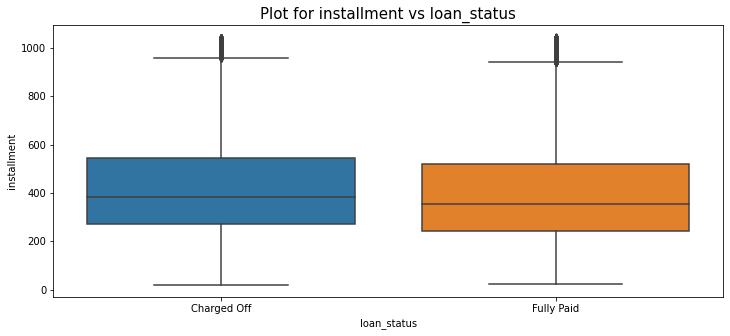

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    420.464201
Fully Paid     396.394871
Name: installment, dtype: float64

__Findings__:

- The monthly dues of the borrowers who clears their loans is lower as compared to those who are charged off.

#### Effect of annual_inc on loan_status

In [ ]:
target = 'loan_status'
col    = 'annual_inc'

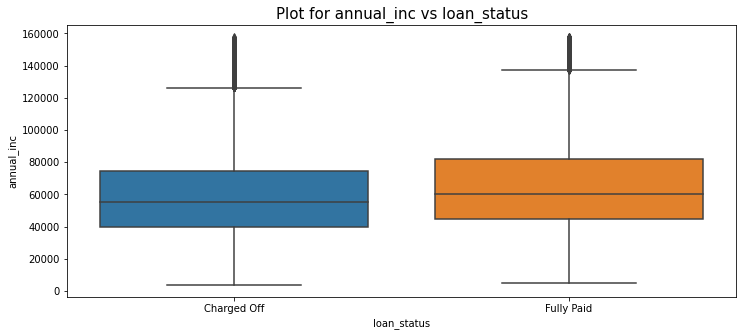

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    59672.669404
Fully Paid     65892.889049
Name: annual_inc, dtype: float64

__Findings__:
- People with higher annual incomes are more likely to pay back their loans.

#### Effect of dti on loan_status

In [ ]:
target = 'loan_status'
col    = 'dti'

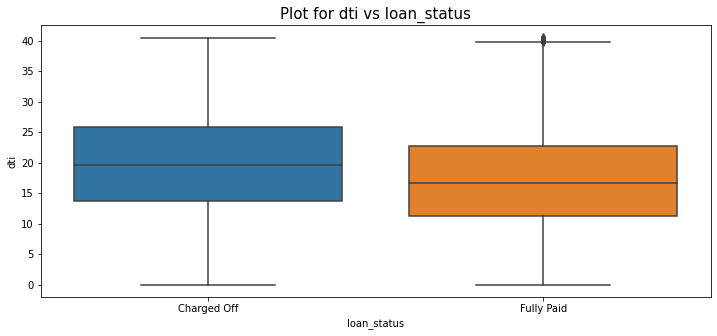

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    19.852882
Fully Paid     17.161782
Name: dti, dtype: float64

__Findings__:

- The dti ratio of the borrowers who clears their loans is lower as compared to those who are charged off.

#### Effect of open_acc on loan_status

In [ ]:
target = 'loan_status'
col    = 'open_acc'

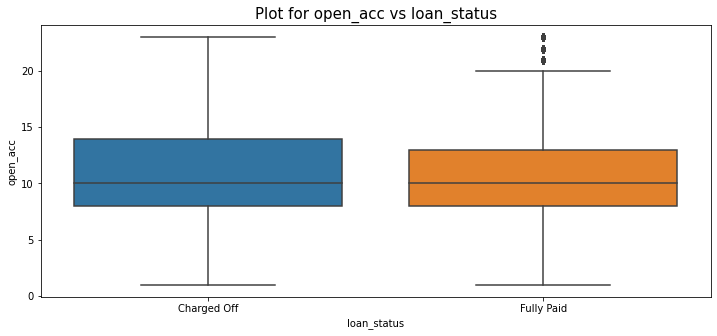

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    11.004808
Fully Paid     10.720898
Name: open_acc, dtype: float64

__Findings__:

- The number of open credit lines in the borrower's credit file, those who clears their loans and those who are charged off, are similar.

#### Effect of pub_rec on loan_status

In [ ]:
target = 'loan_status'
col    = 'pub_rec'

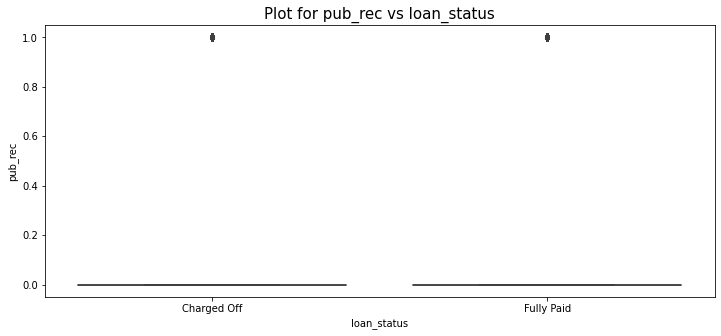

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    0.148502
Fully Paid     0.143932
Name: pub_rec, dtype: float64

__Findings__:

- The Number of derogatory public records of the borrowers, those who clears their loans and those who are charged off, are similar.

#### Effect of revol_bal on loan_status

In [ ]:
target = 'loan_status'
col    = 'revol_bal'

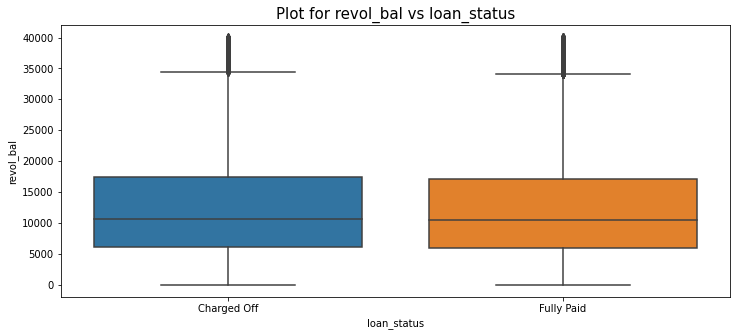

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    12621.40164
Fully Paid     12436.40428
Name: revol_bal, dtype: float64

__Findings__:

- The total credit revolving balance of the borrowers, those who clears their loans and those who are charged off, are similar.

#### Effect of revol_util on loan_status

In [ ]:
target = 'loan_status'
col    = 'revol_util'

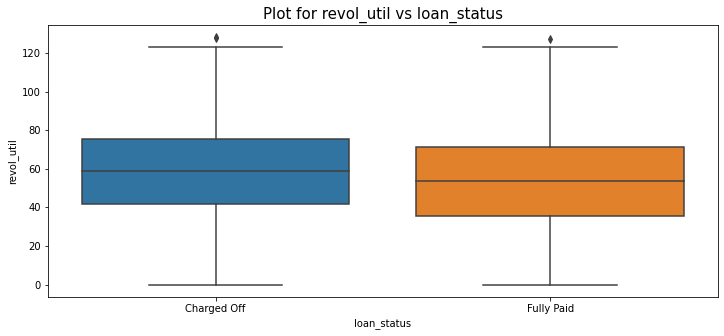

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    57.859784
Fully Paid     53.016443
Name: revol_util, dtype: float64

__Findings__:

- The average revolving line utilization rate of the borrowers who clear their loans completely is lower than those who are charged off.


#### Effect of total_acc on loan_status

In [ ]:
target = 'loan_status'
col    = 'total_acc'

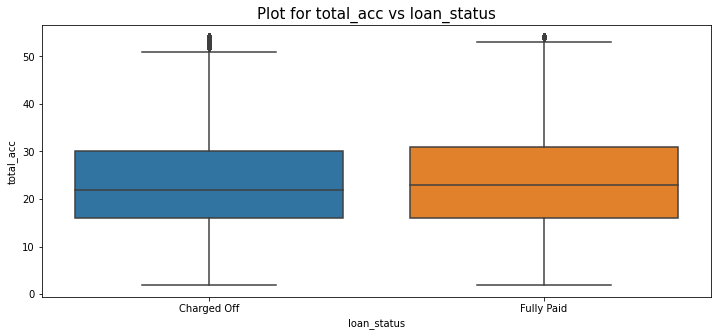

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    23.413787
Fully Paid     24.006012
Name: total_acc, dtype: float64

__Findings__:

- The average number of credit lines of the borrowers, those who clear their loans and those who are charged off, are similar.

#### Effect of mort_acc on loan_status

In [ ]:
target = 'loan_status'
col    = 'mort_acc'

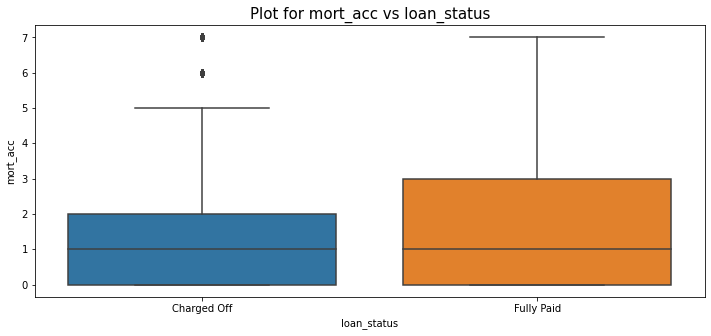

In [ ]:
bi_cat_plot(cleaned_df, col)

In [ ]:
cleaned_df.groupby(target)[col].mean()

loan_status
Charged Off    1.293747
Fully Paid     1.589946
Name: mort_acc, dtype: float64

__Findings__:

- The average number of mortgage accounts is similar for the borrowers who clears their loans completely and those who are charged off.


### Pairplot, Correlation

<Figure size 1080x504 with 0 Axes>

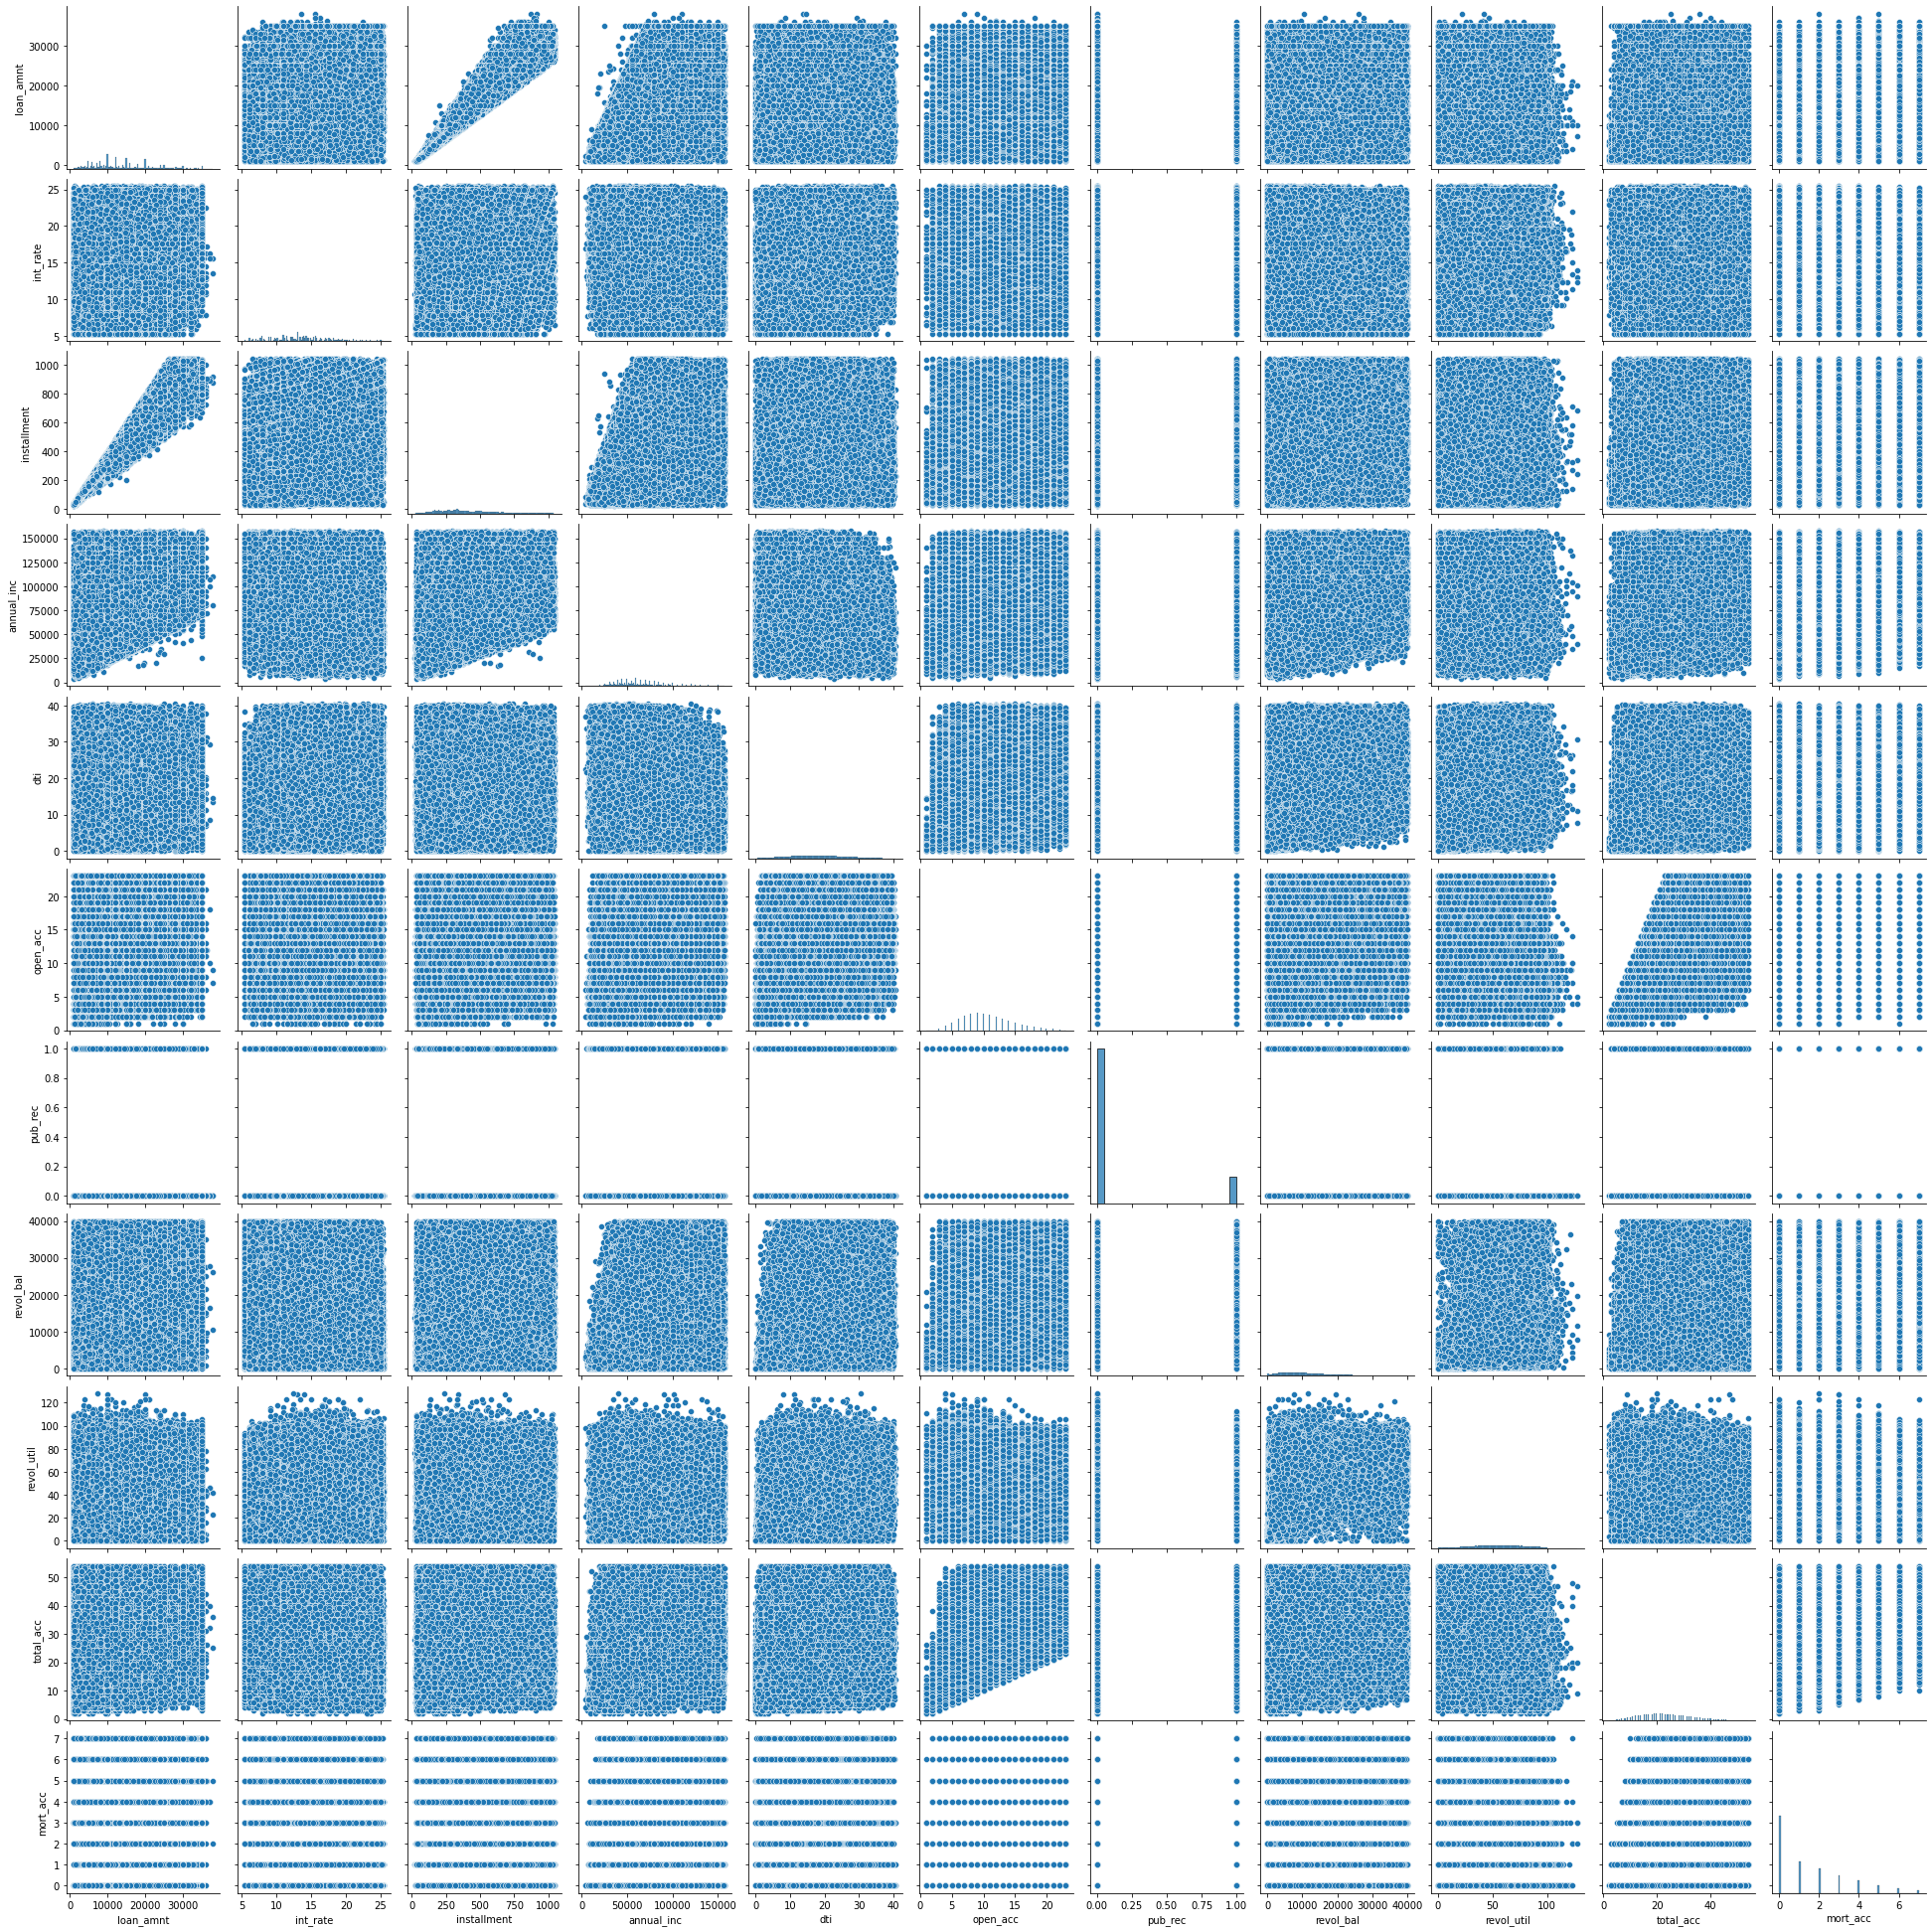

In [ ]:
plt.figure(figsize=(15,7))
sns.pairplot(cleaned_df)
plt.show()

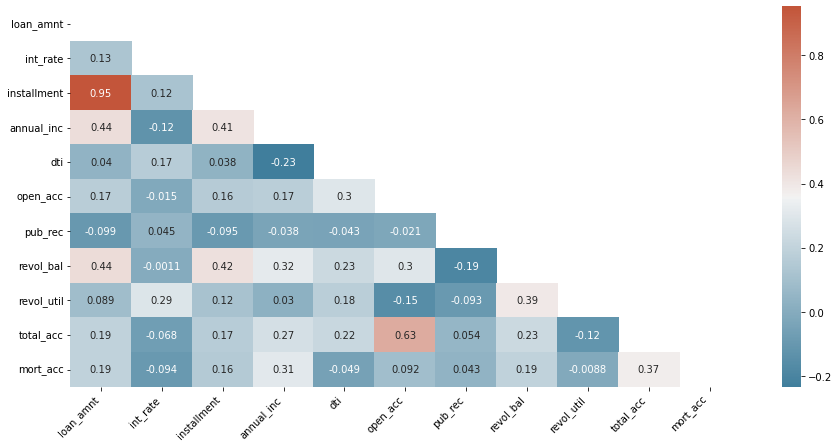

In [ ]:
# Correlation between different variables
corr = cleaned_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(15, 7))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

__Findings:__
- There are strong positive correlation between some of the feature pairs
- - "installment" and "loan_amnt" (0.95)
- - "total_acc" and "open_acc" (0.63)
- - "annual_inc" and "loan_amt" (0.44)
- - "revol_bal" and "loan_amt" (0.44)
- - "annual_inc" and "installment" (0.41)
- - "revol_bal" and "installment" (0.42)

- The correlation between rest of the feature pairs are weak

### Categoricals

#### term vs loan_status

In [ ]:
pd.crosstab(cleaned_df['term'], cleaned_df['loan_status'], normalize=True)

loan_status  Charged Off  Fully Paid
term                                
 36 months      0.126681    0.649256
 60 months      0.074273    0.149790

__Findings__
- People with repayment term of 36months are more likely to pay back their loans.

#### grade vs loan_status

In [ ]:
pd.crosstab(cleaned_df['grade'], cleaned_df['loan_status'], normalize=True)

loan_status  Charged Off  Fully Paid
grade                               
A               0.009588    0.140728
B               0.038549    0.263059
C               0.060935    0.217594
D               0.048933    0.114408
E               0.030754    0.048069
F               0.011798    0.014762
G               0.000397    0.000427

__Findings__
- People with Grade A are more likely to pay back their loan.

#### emp_length vs loan_status

In [ ]:
pd.crosstab(cleaned_df['emp_length'], cleaned_df['loan_status'], normalize=True)

loan_status  Charged Off  Fully Paid
emp_length                          
1 year          0.013943    0.054615
10+ years       0.061781    0.269309
2 years         0.018881    0.075696
3 years         0.016885    0.066459
4 years         0.012190    0.049402
5 years         0.013886    0.056486
6 years         0.010990    0.045264
7 years         0.011194    0.045799
8 years         0.010804    0.042015
9 years         0.008616    0.033288
< 1 year        0.017667    0.064830

__Findings__
- People with 10+ years of employment are more likely to pay back the loans

#### home_ownership vs loan_status

In [ ]:
pd.crosstab(cleaned_df['home_ownership'], cleaned_df['loan_status'], normalize=True)

loan_status     Charged Off  Fully Paid
home_ownership                         
ANY                0.000000    0.000007
MORTGAGE           0.082905    0.396107
NONE               0.000024    0.000054
OTHER              0.000024    0.000085
OWN                0.020224    0.076355
RENT               0.097778    0.326438

__Findings__
- People who have their properties on mortgage are more likely to pack pack their loans

# Data Preparation + Modelling

Before we proceed further, we will split the data into train, validation, and test set. 

As we are dealing with an imbalanced data, we will do __stratified splitting__ instead of __random splitting__.

In [ ]:
from sklearn.model_selection import train_test_split

target_dict = {'Charged Off': 1, 'Fully Paid': 0}

Y = cleaned_df['loan_status'].map(target_dict)
X = cleaned_df.drop(columns=['loan_status'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val   = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print('-'*15, 'Shapes', '-'*15)
print(f'Train      data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')
print(f'Test       data shape: {x_test.shape}')

--------------- Shapes ---------------
Train      data shape: (188769, 21)
Validation data shape: (47193, 21)
Test       data shape: (58991, 21)


### Impute Missing Values

Before we proceed, there are missing values in the dataset. We will fill them first.

In [ ]:
print(x_train.isna().sum())

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length              9510
home_ownership             0
annual_inc                 0
verification_status        0
purpose                    0
dti                        0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
initial_list_status        0
mort_acc                   0
pub_rec_bankruptcies       0
states                     0
dtype: int64


In [ ]:
print(x_val.isna().sum())

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length              2420
home_ownership             0
annual_inc                 0
verification_status        0
purpose                    0
dti                        0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
initial_list_status        0
mort_acc                   0
pub_rec_bankruptcies       0
states                     0
dtype: int64


In [ ]:
print(x_test.isna().sum())

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length              2954
home_ownership             0
annual_inc                 0
verification_status        0
purpose                    0
dti                        0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
initial_list_status        0
mort_acc                   0
pub_rec_bankruptcies       0
states                     0
dtype: int64


As the column is categorical, we will use the mode value to impute the missing values.

In [ ]:
impute_val = x_train['emp_length'].mode()[0]
values = {"emp_length": impute_val}

x_train.fillna(value=values, inplace=True)
x_val.fillna(value=values, inplace=True)
x_test.fillna(value=values, inplace=True)

In [ ]:
x_train.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
purpose                 0
dti                     0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
mort_acc                0
pub_rec_bankruptcies    0
states                  0
dtype: int64

## Modelling - Iteration 1

- Using only the given features

We will encode the categorical features and scale the numerical features before modelling.

In [ ]:
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', \
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']

cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', \
            'purpose', 'initial_list_status', 'pub_rec_bankruptcies']

#### Encode categoricals


In [ ]:
x_train_ohe = pd.get_dummies(x_train[cat_cols], drop_first=True)
x_train_ohe.head(3)

term_ 60 months  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
32852                 0        1        0        0        0        0        0   
140052                0        0        1        0        0        0        0   
268771                0        1        0        0        0        0        0   

        emp_length_10+ years  emp_length_2 years  emp_length_3 years  ...  \
32852                      0                   0                   0  ...   
140052                     0                   0                   0  ...   
268771                     0                   0                   0  ...   

        purpose_wedding  initial_list_status_w  pub_rec_bankruptcies_1.0  \
32852                 0                      0                         1   
140052                0                      0                         0   
268771                0                      1                         0   

        pub_rec_bankruptcies_2.0  pub_rec_bankruptcies_3.0  \
32852                          0                         0   
140052                         0                         0   
268771                         0                         0   

        pub_rec_bankruptcies_4.0  pub_rec_bankruptcies_5.0  \
32852                          0                         0   
140052                         0                         0   
268771                         0                         0   

        pub_rec_bankruptcies_6.0  pub_rec_bankruptcies_7.0  \
32852                          0                         0   
140052                         0                         0   
268771                         0                         0   

        pub_rec_bankruptcies_8.0  
32852                          0  
140052                         0  
268771                         0  

[3 rows x 46 columns]

In [ ]:
x_val_ohe  = pd.get_dummies(x_val[cat_cols], drop_first=True)
x_test_ohe = pd.get_dummies(x_test[cat_cols], drop_first=True)

#### Scale numericals

In [ ]:
for col in num_cols:
    sc = StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train_ohe[col] = sc.transform(x_train[col].values.reshape(-1, 1))
    x_val_ohe[col]   = sc.transform(x_val[col].values.reshape(-1, 1))
    x_test_ohe[col]  = sc.transform(x_test[col].values.reshape(-1, 1))

### Hyperparameter Tuning

We now have our data ready for modelling. 


As we have imbalanced data, we are using F1-score to measure the performance.

In [ ]:
train_scores = []
val_scores = []

for la in tqdm(np.logspace(-2, 3, 50)):
    lr_hp_1 = LogisticRegression(C=1/la)
    lr_hp_1.fit(x_train_ohe, y_train)

    train_score = f1_score(y_train, lr_hp_1.predict(x_train_ohe))
    val_score = f1_score(y_val, lr_hp_1.predict(x_val_ohe))

    train_scores.append(train_score)
    val_scores.append(val_score)

100%|██████████| 50/50 [04:11<00:00,  5.04s/it]


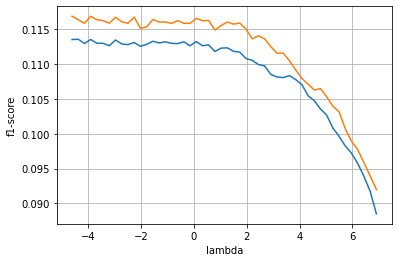

In [ ]:
plt.figure()
plt.plot(list(np.log(np.logspace(-2, 3, 50))), train_scores, label="train")
plt.plot(list(np.log(np.logspace(-2, 3, 50))), val_scores, label="val")
plt.xlabel("lambda (in log space)")
plt.ylabel("f1-score")
plt.grid()
plt.show()

In [ ]:
np.exp(-4)

0.01831563888873418

__Findings__

The highest validation score is at around lambda = 0.018. So will pick lambda = 0.018 to be the best hyperparameter value.



### Final model

In [ ]:
best_la = np.exp(-4)

lr1 = LogisticRegression(C=1/best_la)
lr1.fit(x_train_ohe, y_train)

y_train_pred = lr1.predict(x_train_ohe)
y_test_pred  = lr1.predict(x_test_ohe)

y_train_pred_proba = lr1.predict_proba(x_train_ohe)[:, 1]
y_test_pred_proba = lr1.predict_proba(x_test_ohe)[:, 1]

In [ ]:
top_1 = pd.DataFrame({
    'Features': lr1.feature_names_in_,
    'Coefficients': lr1.coef_[0]
}).sort_values(by='Coefficients', ascending=False)
top_1

Features  Coefficients
5                               grade_F      1.996246
6                               grade_G      1.989292
4                               grade_E      1.773759
3                               grade_D      1.517405
2                               grade_C      1.134690
0                       term_ 60 months      0.628633
1                               grade_B      0.617915
34               purpose_small_business      0.481609
30                      purpose_medical      0.251309
48                          installment      0.207588
22  verification_status_Source Verified      0.202960
50                                  dti      0.188302
31                       purpose_moving      0.183314
27             purpose_home_improvement      0.157199
33             purpose_renewable_energy      0.140065
29               purpose_major_purchase      0.131475
51                             open_acc      0.128679
23         verification_status_Verified      0.115059
54                           revol_util      0.099451
35                     purpose_vacation      0.097352
32                        purpose_other      0.070004
52                              pub_rec      0.056389
25           purpose_debt_consolidation      0.052494
7                  emp_length_10+ years      0.047196
16                  emp_length_< 1 year      0.042178
15                   emp_length_9 years      0.039252
14                   emp_length_8 years      0.029932
24                  purpose_credit_card      0.015177
18                  home_ownership_NONE      0.008727
28                        purpose_house      0.002763
26                  purpose_educational      0.000000
39             pub_rec_bankruptcies_2.0      0.000000
45             pub_rec_bankruptcies_8.0      0.000000
44             pub_rec_bankruptcies_7.0      0.000000
42             pub_rec_bankruptcies_5.0      0.000000
41             pub_rec_bankruptcies_4.0      0.000000
40             pub_rec_bankruptcies_3.0      0.000000
43             pub_rec_bankruptcies_6.0      0.000000
37                initial_list_status_w     -0.012855
8                    emp_length_2 years     -0.015748
12                   emp_length_6 years     -0.015989
11                   emp_length_5 years     -0.016403
9                    emp_length_3 years     -0.023230
10                   emp_length_4 years     -0.029645
56                             mort_acc     -0.032377
19                 home_ownership_OTHER     -0.044920
13                   emp_length_7 years     -0.049509
53                            revol_bal     -0.075583
55                            total_acc     -0.104471
47                             int_rate     -0.108462
46                            loan_amnt     -0.108579
38             pub_rec_bankruptcies_1.0     -0.164284
49                           annual_inc     -0.197312
21                  home_ownership_RENT     -0.556690
36                      purpose_wedding     -0.695721
20                   home_ownership_OWN     -0.699147
17              home_ownership_MORTGAGE     -0.803315

__Summary__
- We have both positive and negative valued coefficients 


The coefficients can be interpreted as follows: 
- __installment - 0.2__: for 1 unit change in installment, Chance of default increases by 0.2
- __home_ownership_MORTGAGE - -0.8__: for 1 unit increase in this feature, the chance of default decreases by 0.8

The signs of coefficient decides if the impact is directly or indirectly related
- (+ve) means directly relation
- (-ve) means indirect relation

For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

__AUC ROC__

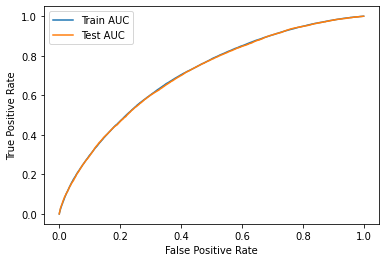

In [ ]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
model1_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model1_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model1_auc_train}, Test AUC: {model1_auc_test}')

Train AUC: 0.7083803384302664, Test AUC: 0.7069489915454129


- We have a descent AUC score
- The gap between train and test is very small. This means, the model generalizes well

__Precion Recall Curve__

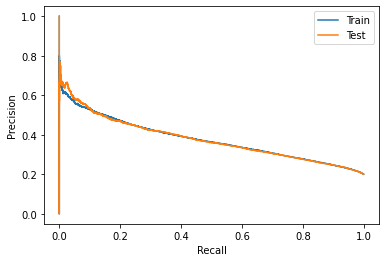

In [ ]:
tr_precision, tr_recall, _ = precision_recall_curve(y_train, y_train_pred_proba)
te_precision, te_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
# plot the precision-recall curves
plt.plot(tr_recall, tr_precision, label='Train')
plt.plot(te_recall, te_precision, label='Test')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

- We want the model to maximize detection of real defaulters, and minimize incorrect predictions as defaulters. Because we do not want to lose out potential clients that can help earn more profit. Hence, maximizing PRECISION is important.

- We do not want people, that are more likely to be defaulters, predicted as non-defaulters. This can lead to more NPAs. Hence maximizing RECALL is also important.

- Increase in PRECISION might decrease RECALL, and vice-versa. Hence we want a sweet spot between the both.

- For the current model, as the FN rate decreases (higher RECALL value), the FP rate increases a lot (lower PRECISION value)

__Classification Report__

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=['Fully Paid', 'Charged Off']))

              precision    recall  f1-score   support

  Fully Paid       0.81      0.99      0.89     47137
 Charged Off       0.57      0.07      0.12     11854

    accuracy                           0.80     58991
   macro avg       0.69      0.53      0.51     58991
weighted avg       0.76      0.80      0.73     58991



- The RECALL for minority class is very bad. We need a better model
- The PRECISION for minority class is also not that great. We need a better model.

## Modelling - Iteration 2 
- Class Re-balance



The target attribute of the data at hand is highly skewed. In the 1st iteration, we trained the model without any class balancing.

Although we have multiple methods to deal with class imbalance, in this notebook we will the upsampling technique called SMOTE.

In [155]:
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', \
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']

cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', \
            'purpose', 'initial_list_status', 'pub_rec_bankruptcies']

#### Encode categoricals


In [156]:
x_train_ohe = pd.get_dummies(x_train[cat_cols], drop_first=True)
x_train_ohe.head(3)

term_ 60 months  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
32852                 0        1        0        0        0        0        0   
140052                0        0        1        0        0        0        0   
268771                0        1        0        0        0        0        0   

        emp_length_10+ years  emp_length_2 years  emp_length_3 years  ...  \
32852                      0                   0                   0  ...   
140052                     0                   0                   0  ...   
268771                     0                   0                   0  ...   

        purpose_wedding  initial_list_status_w  pub_rec_bankruptcies_1.0  \
32852                 0                      0                         1   
140052                0                      0                         0   
268771                0                      1                         0   

        pub_rec_bankruptcies_2.0  pub_rec_bankruptcies_3.0  \
32852                          0                         0   
140052                         0                         0   
268771                         0                         0   

        pub_rec_bankruptcies_4.0  pub_rec_bankruptcies_5.0  \
32852                          0                         0   
140052                         0                         0   
268771                         0                         0   

        pub_rec_bankruptcies_6.0  pub_rec_bankruptcies_7.0  \
32852                          0                         0   
140052                         0                         0   
268771                         0                         0   

        pub_rec_bankruptcies_8.0  
32852                          0  
140052                         0  
268771                         0  

[3 rows x 46 columns]

In [157]:
x_val_ohe  = pd.get_dummies(x_val[cat_cols], drop_first=True)
x_test_ohe = pd.get_dummies(x_test[cat_cols], drop_first=True)

#### Scale numericals

In [158]:
for col in num_cols:
    sc = StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train_ohe[col] = sc.transform(x_train[col].values.reshape(-1, 1))
    x_val_ohe[col]   = sc.transform(x_val[col].values.reshape(-1, 1))
    x_test_ohe[col]  = sc.transform(x_test[col].values.reshape(-1, 1))

#### Class Balancing

In [159]:
oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train_ohe, y_train)

In [160]:
print('Ratio of labels before balancing:')
print(y_train.value_counts())
print('\n'*2)
print('Ratio of labels after balancing:')
print(y_train_smote.value_counts())

Ratio of labels before balancing:
0    150835
1     37934
Name: loan_status, dtype: int64



Ratio of labels after balancing:
1    150835
0    150835
Name: loan_status, dtype: int64


### Hyperparameter Tuning

We now have our data ready for modelling. 


In [161]:
train_scores = []
val_scores = []

for la in tqdm(np.logspace(-1, 4, 50)):
    lr_hp_2 = LogisticRegression(C=1/la) 
    lr_hp_2.fit(x_train_smote, y_train_smote)

    train_score = f1_score(y_train_smote, lr_hp_2.predict(x_train_smote))
    val_score = f1_score(y_val, lr_hp_2.predict(x_val_ohe))

    train_scores.append(train_score)
    val_scores.append(val_score)

100%|██████████| 50/50 [07:38<00:00,  9.17s/it]


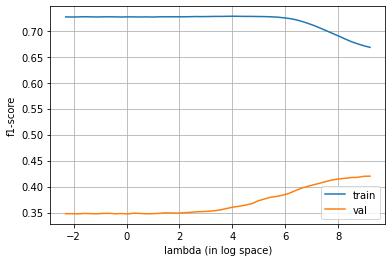

In [162]:
plt.figure()
plt.plot(list(np.log(np.logspace(-1, 4, 50))), train_scores, label="train")
plt.plot(list(np.log(np.logspace(-1, 4, 50))), val_scores, label="val")
plt.xlabel("lambda (in log space)")
plt.ylabel("f1-score")
plt.legend()
plt.grid()
plt.show()

In [166]:
# the last point in the graph
np.logspace(-1, 4, 50)[-1]

10000.0

__Findings__

The highest validation score is at around lambda = 10000. So will pick lambda = 10000 to be the best hyperparameter value.



### Final model

In [167]:
best_la = 10000

lr_2 = LogisticRegression(C=1/best_la)
lr_2.fit(x_train_smote, y_train_smote)

y_train_pred = lr_2.predict(x_train_smote)
y_test_pred  = lr_2.predict(x_test_ohe)

y_train_pred_proba = lr_2.predict_proba(x_train_smote)[:, 1]
y_test_pred_proba = lr_2.predict_proba(x_test_ohe)[:, 1]

In [168]:
top_2 = pd.DataFrame({
    'Features': lr_2.feature_names_in_,
    'Coefficients': lr_2.coef_[0]
}).sort_values(by='Coefficients', ascending=False)
top_2

Features  Coefficients
47                             int_rate      0.392628
46                            loan_amnt      0.198076
50                                  dti      0.197533
0                       term_ 60 months      0.171705
51                             open_acc      0.101195
54                           revol_util      0.088489
52                              pub_rec      0.037291
3                               grade_D      0.033800
4                               grade_E      0.023727
2                               grade_C      0.018843
43             pub_rec_bankruptcies_6.0      0.000000
39             pub_rec_bankruptcies_2.0      0.000000
40             pub_rec_bankruptcies_3.0      0.000000
41             pub_rec_bankruptcies_4.0      0.000000
42             pub_rec_bankruptcies_5.0      0.000000
44             pub_rec_bankruptcies_7.0      0.000000
45             pub_rec_bankruptcies_8.0      0.000000
26                  purpose_educational      0.000000
18                  home_ownership_NONE     -0.000292
19                 home_ownership_OTHER     -0.000529
33             purpose_renewable_energy     -0.003442
6                               grade_G     -0.004207
5                               grade_F     -0.016684
36                      purpose_wedding     -0.021296
28                        purpose_house     -0.024548
34               purpose_small_business     -0.025780
48                          installment     -0.027670
31                       purpose_moving     -0.029988
35                     purpose_vacation     -0.030405
30                      purpose_medical     -0.042096
38             pub_rec_bankruptcies_1.0     -0.046707
21                  home_ownership_RENT     -0.053952
53                            revol_bal     -0.054429
56                             mort_acc     -0.060577
22  verification_status_Source Verified     -0.066944
29               purpose_major_purchase     -0.071314
55                            total_acc     -0.089477
25           purpose_debt_consolidation     -0.100611
7                  emp_length_10+ years     -0.112938
27             purpose_home_improvement     -0.116003
32                        purpose_other     -0.129399
15                   emp_length_9 years     -0.130770
14                   emp_length_8 years     -0.148206
1                               grade_B     -0.152251
16                  emp_length_< 1 year     -0.158497
12                   emp_length_6 years     -0.171319
13                   emp_length_7 years     -0.172527
10                   emp_length_4 years     -0.173302
11                   emp_length_5 years     -0.174904
20                   home_ownership_OWN     -0.175859
37                initial_list_status_w     -0.176361
23         verification_status_Verified     -0.179330
9                    emp_length_3 years     -0.183346
8                    emp_length_2 years     -0.184204
17              home_ownership_MORTGAGE     -0.187129
24                  purpose_credit_card     -0.187291
49                           annual_inc     -0.195581

__Summary__
- We have both positive and negative valued coefficients 


The coefficients can be interpreted as follows: 
- __int_rate - 0.39__: for 1 unit change in int_rate, Chance of default increases by 0.39
- __annual_inc - -0.19__: for 1 unit increase in annual income, the chance of default decreases by 0.19

The signs of coefficient decides if the impact is directly or indirectly related
- (+ve) means directly relation
- (-ve) means indirect relation

For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

__AUC ROC__

In [169]:
model2_auc_train = roc_auc_score(y_train_smote, y_train_pred_proba)
model2_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model2_auc_train}, Test AUC: {model2_auc_test}')

Train AUC: 0.7301203825769217, Test AUC: 0.696100846858236


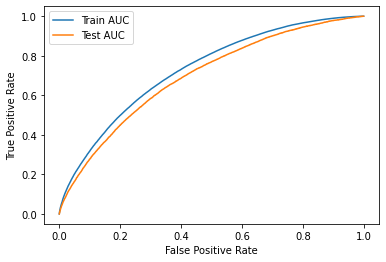

In [170]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train_smote, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent train and test AUC score.
- The gap between train and test is low. This means, the model is generalizing well.

__Precion Recall Curve__

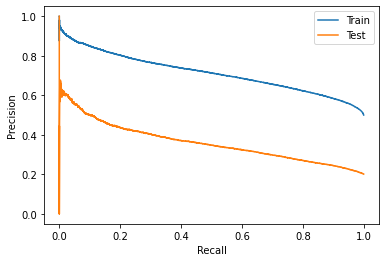

In [171]:
tr_precision, tr_recall, _ = precision_recall_curve(y_train_smote, y_train_pred_proba)
te_precision, te_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
# plot the precision-recall curves
plt.plot(tr_recall, tr_precision, label='Train')
plt.plot(te_recall, te_precision, label='Test')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

- We want the model to maximize detection of real defaulters, and minimize incorrect predictions as defaulters. Because we do not want to lose out potential clients that can help earn more profit. Hence, maximizing PRECISION is important.

- We do not want people, that are more likely to be defaulters, predicted as non-defaulters. This can lead to more NPAs. Hence maximizing RECALL is also important.

- Increase in PRECISION might decrease RECALL, and vice-versa. Hence we want a sweet spot between the both.

- For the current model, as the FN rate decreases (higher RECALL value), the FP rate increases a lot (lower PRECISION value) for the test data.

__Classification Report__

In [172]:
print(classification_report(y_test, y_test_pred, target_names=['Fully Paid', 'Charged Off']))

              precision    recall  f1-score   support

  Fully Paid       0.88      0.66      0.75     47137
 Charged Off       0.32      0.63      0.42     11854

    accuracy                           0.65     58991
   macro avg       0.60      0.65      0.59     58991
weighted avg       0.76      0.65      0.69     58991



- The RECALL for minority class is descent. But the PRECISION for minority class is very bad. 

## Modelling - Iteration 3
- Class Re-balance
- Feature Engineering:
- - extracting state code from Address
- - creation of flags from "pub_rec", "mort_acc", and "pub_rec_bankruptcies"



The target attribute of the data at hand is highly skewed. In the 1st iteration, we trained the model without any class balancing. In iteration 2, we did class balancing using the upsampling technique called SMOTE. In this iteration, we will use extract few more features and use them in our model.

In [ ]:
def flag_mapper(x):
    if x > 1:
        return 1
    else:
        return 0

x_train['pub_rec_flag'] = x_train['pub_rec'].map(flag_mapper)
x_train['mort_acc_flag'] = x_train['mort_acc'].map(flag_mapper)
x_train['pub_rec_bankruptcies_flag'] = x_train['pub_rec_bankruptcies'].map(flag_mapper)

x_val['pub_rec_flag'] = x_val['pub_rec'].map(flag_mapper)
x_val['mort_acc_flag'] = x_val['mort_acc'].map(flag_mapper)
x_val['pub_rec_bankruptcies_flag'] = x_val['pub_rec_bankruptcies'].map(flag_mapper)

x_test['pub_rec_flag'] = x_test['pub_rec'].map(flag_mapper)
x_test['mort_acc_flag'] = x_test['mort_acc'].map(flag_mapper)
x_test['pub_rec_bankruptcies_flag'] = x_test['pub_rec_bankruptcies'].map(flag_mapper)

In [ ]:
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', \
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']

cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', \
            'purpose', 'initial_list_status', 'pub_rec_bankruptcies', 'states',     \
            'pub_rec_flag', 'mort_acc_flag', 'pub_rec_bankruptcies_flag']

#### Encode categoricals


In [ ]:
x_train_ohe = pd.get_dummies(x_train[cat_cols], drop_first=True)
x_train_ohe.head(3)

pub_rec_flag  mort_acc_flag  pub_rec_bankruptcies_flag  \
32852              0              0                          0   
140052             0              1                          0   
268771             0              0                          0   

        term_ 60 months  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
32852                 0        1        0        0        0        0        0   
140052                0        0        1        0        0        0        0   
268771                0        1        0        0        0        0        0   

        ...  states_SD  states_TN  states_TX  states_UT  states_VA  states_VT  \
32852   ...          0          0          0          0          0          0   
140052  ...          0          0          0          0          0          0   
268771  ...          0          0          0          0          0          0   

        states_WA  states_WI  states_WV  states_WY  
32852           0          0          0          0  
140052          0          0          0          0  
268771          0          0          0          0  

[3 rows x 102 columns]

In [ ]:
x_val_ohe  = pd.get_dummies(x_val[cat_cols], drop_first=True)
x_test_ohe = pd.get_dummies(x_test[cat_cols], drop_first=True)

#### Scale numericals

In [ ]:
for col in num_cols:
    sc = StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train_ohe[col] = sc.transform(x_train[col].values.reshape(-1, 1))
    x_val_ohe[col]   = sc.transform(x_val[col].values.reshape(-1, 1))
    x_test_ohe[col]  = sc.transform(x_test[col].values.reshape(-1, 1))

#### Class Balancing

In [ ]:
oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train_ohe, y_train)

In [ ]:
print('Ratio of labels before balancing:')
print(y_train.value_counts())
print('\n'*2)
print('Ratio of labels after balancing:')
print(y_train_smote.value_counts())

Ratio of labels before balancing:
0    150835
1     37934
Name: loan_status, dtype: int64



Ratio of labels after balancing:
1    150835
0    150835
Name: loan_status, dtype: int64


### Hyperparameter Tuning

We now have our data ready for modelling. 

In [ ]:
train_scores = []
val_scores = []

for la in tqdm(np.logspace(0, 4, 50)):
    lr_hp_3 = LogisticRegression(C=1/la)
    lr_hp_3.fit(x_train_smote, y_train_smote)

    train_score = f1_score(y_train_smote, lr_hp_3.predict(x_train_smote))
    val_score = f1_score(y_val, lr_hp_3.predict(x_val_ohe))

    train_scores.append(train_score)
    val_scores.append(val_score)

100%|██████████| 50/50 [08:12<00:00,  9.85s/it]


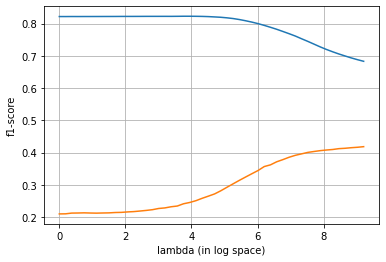

In [ ]:
plt.figure()
plt.plot(list(np.log(np.logspace(0, 4, 50))), train_scores, label="train")
plt.plot(list(np.log(np.logspace(0, 4, 50))), val_scores, label="val")
plt.xlabel("lambda (in log space)")
plt.ylabel("f1-score")
plt.grid()
plt.show()

In [ ]:
# the last point in the graph
np.logspace(0, 4, 50)[-1]

10000.0

__Findings__

The highest validation score is at around lambda = 10000. So will pick lambda = 10000 to be the best hyperparameter value.



### Final model

In [ ]:
best_la = 10000

lr_3 = LogisticRegression(C=1/best_la)
lr_3.fit(x_train_smote, y_train_smote)

y_train_pred = lr_3.predict(x_train_smote)
y_test_pred  = lr_3.predict(x_test_ohe)

y_train_pred_proba = lr_3.predict_proba(x_train_smote)[:, 1]
y_test_pred_proba = lr_3.predict_proba(x_test_ohe)[:, 1]

In [ ]:
top_3 = pd.DataFrame({
    'Features': lr_3.feature_names_in_,
    'Coefficients': lr_3.coef_[0]
}).sort_values(by='Coefficients', ascending=False)
top_3

Features  Coefficients
103                      int_rate      0.389638
102                     loan_amnt      0.201163
106                           dti      0.200223
3                 term_ 60 months      0.166078
107                      open_acc      0.098010
..                            ...           ...
12             emp_length_3 years     -0.191049
26   verification_status_Verified     -0.192411
27            purpose_credit_card     -0.196652
11             emp_length_2 years     -0.196769
20        home_ownership_MORTGAGE     -0.205269

[113 rows x 2 columns]

__Summary__
- We have both positive and negative valued coefficients 


The coefficients can be interpreted as follows: 
- __int_rate - 0.389__: for 1 unit change in int_rate, Chance of default increases by 0.389
- __home_ownership_MORTGAGE - -0.20__: for 1 unit increase in home_ownership_MORTGAGE, the chance of default decreases by 0.19

The signs of coefficient decides if the impact is directly or indirectly related
- (+ve) means directly relation
- (-ve) means indirect relation

For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

__AUC ROC__

In [ ]:
model3_auc_train = roc_auc_score(y_train_smote, y_train_pred_proba)
model3_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model3_auc_train}, Test AUC: {model3_auc_test}')

Train AUC: 0.7507683627844777, Test AUC: 0.6952286526114111


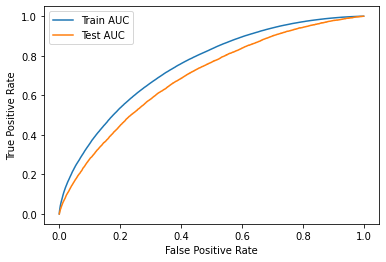

In [ ]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train_smote, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent AUC score
- The gap between train and test is very small. This means, the model generalizes well

__Precion Recall Curve__

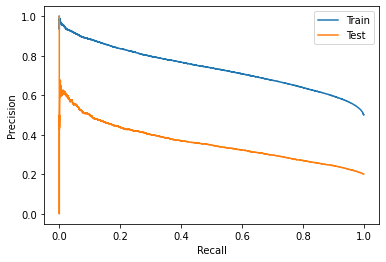

In [ ]:
tr_precision, tr_recall, _ = precision_recall_curve(y_train_smote, y_train_pred_proba)
te_precision, te_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
# plot the precision-recall curves
plt.plot(tr_recall, tr_precision, label='Train')
plt.plot(te_recall, te_precision, label='Test')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

- We want the model to maximize detection of real defaulters, and minimize incorrect predictions as defaulters. Because we do not want to lose out potential clients that can help earn more profit. Hence, maximizing PRECISION is important.

- We do not want people, that are more likely to be defaulters, predicted as non-defaulters. This can lead to more NPAs. Hence maximizing RECALL is also important.

- Increase in PRECISION might decrease RECALL, and vice-versa. Hence we want a sweet spot between the both.

- For the current model, as the FN rate decreases (higher RECALL value), the FP rate increases a lot (lower PRECISION value) for the test data.

__Classification Report__

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=['Fully Paid', 'Charged Off']))

              precision    recall  f1-score   support

  Fully Paid       0.87      0.68      0.76     47137
 Charged Off       0.32      0.61      0.42     11854

    accuracy                           0.66     58991
   macro avg       0.60      0.64      0.59     58991
weighted avg       0.76      0.66      0.69     58991



- The RECALL for minority class is descent. But the PRECISION for minority class is very bad. 

## Summary

In [154]:
print("-->  Minorty Class Precision, Recall, and F1 Score <--")

precisions = [0.57, 0.32, 0.32]
recalls    = [0.07, 0.63, 0.61]
f1_scores  = [0.12, 0.42, 0.42]

x = PrettyTable(["Model", "Precision", "Recall", "F1-Score"])
i = 1
for a, b, c in zip(precisions, recalls, f1_scores):
    x.add_row(['Model '+str(i), a, b, c])
    x.add_row([' ', ' ', ' ', ' '])
    i += 1
print(x)

-->  Minorty Class Precision, Recall, and F1 Score <--
+---------+-----------+--------+----------+
|  Model  | Precision | Recall | F1-Score |
+---------+-----------+--------+----------+
| Model 1 |    0.57   |  0.07  |   0.12   |
|         |           |        |          |
| Model 2 |    0.32   |  0.63  |   0.42   |
|         |           |        |          |
| Model 3 |    0.32   |  0.61  |   0.42   |
|         |           |        |          |
+---------+-----------+--------+----------+


- The best scores we have is for Model 2. This model was trained after class balancing.

## Modelling - Iteration 4 (FINAL)
- Improving Model Iteration 2 by using only the top features for Modelling



In [ ]:
top_2

Features  Coefficients
47                             int_rate      0.395323
50                                  dti      0.200219
46                            loan_amnt      0.199722
0                       term_ 60 months      0.169889
51                             open_acc      0.098011
54                           revol_util      0.088690
52                              pub_rec      0.039291
3                               grade_D      0.035991
4                               grade_E      0.021554
2                               grade_C      0.019513
43             pub_rec_bankruptcies_6.0      0.000000
39             pub_rec_bankruptcies_2.0      0.000000
40             pub_rec_bankruptcies_3.0      0.000000
41             pub_rec_bankruptcies_4.0      0.000000
42             pub_rec_bankruptcies_5.0      0.000000
45             pub_rec_bankruptcies_8.0      0.000000
44             pub_rec_bankruptcies_7.0      0.000000
26                  purpose_educational      0.000000
18                  home_ownership_NONE     -0.000289
19                 home_ownership_OTHER     -0.000526
33             purpose_renewable_energy     -0.003429
6                               grade_G     -0.003942
5                               grade_F     -0.014534
36                      purpose_wedding     -0.021307
48                          installment     -0.023246
28                        purpose_house     -0.024372
34               purpose_small_business     -0.026490
31                       purpose_moving     -0.029270
35                     purpose_vacation     -0.029919
30                      purpose_medical     -0.040715
38             pub_rec_bankruptcies_1.0     -0.044740
21                  home_ownership_RENT     -0.054794
53                            revol_bal     -0.059144
22  verification_status_Source Verified     -0.059606
56                             mort_acc     -0.060434
29               purpose_major_purchase     -0.072887
55                            total_acc     -0.084534
25           purpose_debt_consolidation     -0.098852
27             purpose_home_improvement     -0.115407
7                  emp_length_10+ years     -0.116937
15                   emp_length_9 years     -0.126298
32                        purpose_other     -0.127834
14                   emp_length_8 years     -0.148298
1                               grade_B     -0.148998
16                  emp_length_< 1 year     -0.154032
12                   emp_length_6 years     -0.167820
37                initial_list_status_w     -0.170114
10                   emp_length_4 years     -0.171090
13                   emp_length_7 years     -0.172463
11                   emp_length_5 years     -0.178777
20                   home_ownership_OWN     -0.179720
23         verification_status_Verified     -0.180059
9                    emp_length_3 years     -0.182635
8                    emp_length_2 years     -0.188275
17              home_ownership_MORTGAGE     -0.195216
24                  purpose_credit_card     -0.195875
49                           annual_inc     -0.199138

__Findings:__

- The following features have high coefficient value (magnitude), ie higher predictive power: "int_rate", "dti", "loan_amt", "term", "open_acc", "revol_util", "annual_inc", "emp_length", "home_ownership" and "purpose".

In [128]:
num_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util']
cat_cols = ['term', 'emp_length', 'home_ownership', 'purpose']

#### Encode categoricals


In [129]:
x_train_ohe = pd.get_dummies(x_train[cat_cols], drop_first=True)
x_train_ohe.head(3)

term_ 60 months  emp_length_10+ years  emp_length_2 years  \
32852                 0                     0                   0   
140052                0                     0                   0   
268771                0                     0                   0   

        emp_length_3 years  emp_length_4 years  emp_length_5 years  \
32852                    0                   0                   0   
140052                   0                   0                   0   
268771                   0                   0                   0   

        emp_length_6 years  emp_length_7 years  emp_length_8 years  \
32852                    0                   0                   0   
140052                   1                   0                   0   
268771                   0                   0                   0   

        emp_length_9 years  ...  purpose_home_improvement  purpose_house  \
32852                    0  ...                         0              0   
140052                   0  ...                         0              0   
268771                   1  ...                         0              0   

        purpose_major_purchase  purpose_medical  purpose_moving  \
32852                        0                0               0   
140052                       0                0               0   
268771                       0                0               0   

        purpose_other  purpose_renewable_energy  purpose_small_business  \
32852               0                         0                       0   
140052              0                         0                       0   
268771              0                         0                       0   

        purpose_vacation  purpose_wedding  
32852                  0                0  
140052                 0                0  
268771                 0                0  

[3 rows x 29 columns]

In [130]:
x_val_ohe  = pd.get_dummies(x_val[cat_cols], drop_first=True)
x_test_ohe = pd.get_dummies(x_test[cat_cols], drop_first=True)

#### Scale numericals

In [131]:
for col in num_cols:
    sc = StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train_ohe[col] = sc.transform(x_train[col].values.reshape(-1, 1))
    x_val_ohe[col]   = sc.transform(x_val[col].values.reshape(-1, 1))
    x_test_ohe[col]  = sc.transform(x_test[col].values.reshape(-1, 1))

#### Class Balancing

In [132]:
oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train_ohe, y_train)

In [133]:
print('Ratio of labels before balancing:')
print(y_train.value_counts())
print('\n'*2)
print('Ratio of labels after balancing:')
print(y_train_smote.value_counts())

Ratio of labels before balancing:
0    150835
1     37934
Name: loan_status, dtype: int64



Ratio of labels after balancing:
1    150835
0    150835
Name: loan_status, dtype: int64


### Hyperparameter Tuning

We now have our data ready for modelling. 


In [138]:
train_scores = []
val_scores = []

for la in tqdm(np.logspace(-3, 4, 100)):
    lr_hp_4 = LogisticRegression(C=1/la) 
    lr_hp_4.fit(x_train_smote, y_train_smote)

    train_score = f1_score(y_train_smote, lr_hp_4.predict(x_train_smote))
    val_score = f1_score(y_val, lr_hp_4.predict(x_val_ohe))

    train_scores.append(train_score)
    val_scores.append(val_score)

100%|██████████| 100/100 [10:59<00:00,  6.59s/it]


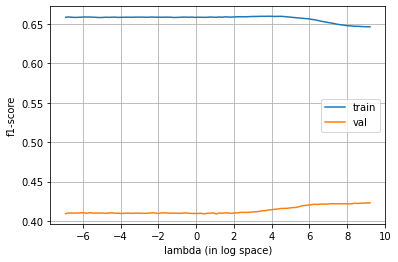

In [139]:
plt.figure()
plt.plot(list(np.log(np.logspace(-3, 4, 100))), train_scores, label="train")
plt.plot(list(np.log(np.logspace(-3, 4, 100))), val_scores, label="val")
plt.xlabel("lambda (in log space)")
plt.ylabel("f1-score")
plt.legend()
plt.grid()
plt.show()

In [145]:
# the last point in the graph
np.logspace(-3, 4, 100)[-1]

10000.0

__Findings__

The highest validation score is at around lambda = 10000. So will pick lambda = 10000 to be the best hyperparameter value.



### Final model

In [146]:
best_la = 10000

lr_4 = LogisticRegression(C=1/best_la)
lr_4.fit(x_train_smote, y_train_smote)

y_train_pred = lr_4.predict(x_train_smote)
y_test_pred  = lr_4.predict(x_test_ohe)

y_train_pred_proba = lr_4.predict_proba(x_train_smote)[:, 1]
y_test_pred_proba = lr_4.predict_proba(x_test_ohe)[:, 1]

In [147]:
top_4 = pd.DataFrame({
    'Features': lr_4.feature_names_in_,
    'Coefficients': lr_4.coef_[0]
}).sort_values(by='Coefficients', ascending=False)
top_4

Features  Coefficients
30                    int_rate      0.452249
0              term_ 60 months      0.198353
32                         dti      0.175528
29                   loan_amnt      0.128869
15         home_ownership_RENT      0.091376
34                  revol_util      0.064783
33                    open_acc      0.038452
18         purpose_educational      0.000000
12         home_ownership_NONE     -0.000282
13        home_ownership_OTHER     -0.000469
25    purpose_renewable_energy     -0.003365
26      purpose_small_business     -0.009269
23              purpose_moving     -0.019227
28             purpose_wedding     -0.019692
20               purpose_house     -0.020611
19    purpose_home_improvement     -0.021051
27            purpose_vacation     -0.021438
1         emp_length_10+ years     -0.021621
22             purpose_medical     -0.024134
17  purpose_debt_consolidation     -0.025223
10         emp_length_< 1 year     -0.036779
8           emp_length_8 years     -0.041724
14          home_ownership_OWN     -0.042773
21      purpose_major_purchase     -0.043817
24               purpose_other     -0.046837
9           emp_length_9 years     -0.049434
2           emp_length_2 years     -0.051076
3           emp_length_3 years     -0.055350
5           emp_length_5 years     -0.060389
4           emp_length_4 years     -0.060439
6           emp_length_6 years     -0.065502
7           emp_length_7 years     -0.069680
16         purpose_credit_card     -0.072851
11     home_ownership_MORTGAGE     -0.127138
31                  annual_inc     -0.214070

__Summary__
- We have both positive and negative valued coefficients 


The coefficients can be interpreted as follows: 
- __int_rate - 0.45__: for 1 unit change in int_rate, chance of default increases by 0.45
- __annual_inc - -0.21__: for 1 unit change in annual income, the chance of default decreases by 0.21

The signs of coefficient decides if the impact is directly or indirectly related
- (+ve) means directly relation
- (-ve) means indirect relation

For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

__AUC ROC__

In [149]:
model4_auc_train = roc_auc_score(y_train_smote, y_train_pred_proba)
model4_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model4_auc_train}, Test AUC: {model4_auc_test}')

Train AUC: 0.7011767523368213, Test AUC: 0.6990807649735692


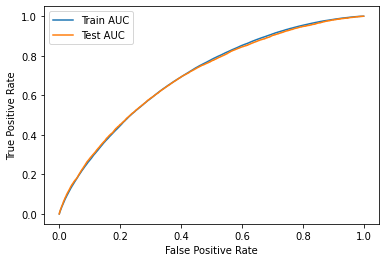

In [150]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train_smote, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent train and test AUC score.
- The gap between train and test is low. This means, the model is generalizing well.

__Precion Recall Curve__

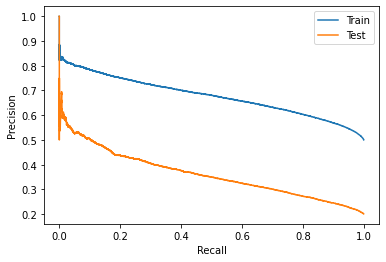

In [151]:
tr_precision, tr_recall, _ = precision_recall_curve(y_train_smote, y_train_pred_proba)
te_precision, te_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
# plot the precision-recall curves
plt.plot(tr_recall, tr_precision, label='Train')
plt.plot(te_recall, te_precision, label='Test')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

- We want the model to maximize detection of real defaulters, and minimize incorrect predictions as defaulters. Because we do not want to lose out potential clients that can help earn more profit. Hence, maximizing PRECISION is important.

- We do not want people, that are more likely to be defaulters, predicted as non-defaulters. This can lead to more NPAs. Hence maximizing RECALL is also important.

- Increase in PRECISION might decrease RECALL, and vice-versa. Hence we want a sweet spot between the both.

- For the current model, as the FN rate decreases (higher RECALL value), the FP rate increases a lot (lower PRECISION value) for the test data.

__Classification Report__

In [152]:
print(classification_report(y_test, y_test_pred, target_names=['Fully Paid', 'Charged Off']))

              precision    recall  f1-score   support

  Fully Paid       0.88      0.65      0.74     47137
 Charged Off       0.31      0.65      0.42     11854

    accuracy                           0.65     58991
   macro avg       0.60      0.65      0.58     58991
weighted avg       0.77      0.65      0.68     58991



- The RECALL for minority class is best out of all the 4 models. But the PRECISION for minority class is still bad.

# Conclusion

- Oversampling helped increase the model performance slightly
- The flag features did not prove to be of much use
- "int_rate", "term", "dti", "loan_amt", "annual_inc", and "home_status_MORTGAGE" have the most predictive power to decide if a borrower will default the loan or not.
- Model 4 is the final model.

# Tradeoff Questions:



Q. How can we make sure that our model can detect real defaulters and there are fewer false positives? This is important as we can lose out on an opportunity to finance more supply chains and earn interest in it. 

__ANS__ We can increase the threshold of classification so that we have better confidence before deciding if a borrower will default or not. This might reduce FP and lead to better precision. 

---



Q Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone. 

__ANS__ We do not want people, that are more likely to be defaulters, predicted as non-defaulters. As this can lead to more NPAs. We can reduce the threshold to reduce FN.


We have to make a business decision as to if we should give more weightage FP or FN, then choose a threshold accordingly to have the desired tradeoff between precision and recall.

# Recommendations:



In [1]:
from prettytable import PrettyTable
observations = [
    """The loan repayment is high when the 'interest rate' and principal 'loan
    amount' is low. Also, loan repayment is high when the 'term' is small.""",

    """People with higher 'income' and people having their property on 
    'mortgage' defaults less. """,
    
    """The 'dti' ratio of the borrowers who clears their loans is lower 
    as compared to those who are charged off.""" ,
    ]


recommendations = [
    """This company should lend out more for 'short term loans', 
    with smaller interest rates and principal.""" ,

    """This company can target the higher income group to extend large
    principal loans, and 'mortgage' loans with attractive low 'interest 
    rate' to earn more profits as interest.""",

    """This company should check 'dti' ratio of a borrower with higher 
    priority to reduce the chances of NPA. The smaller the better.""",

    ]

x = PrettyTable(["Sl no", "Observations", "Recommendations"])
i = 1
for a, b in zip(observations, recommendations):
    x.add_row([i, a, b])
    x.add_row([' ', ' ', ' '])
    i += 1
print(x)

+-------+----------------------------------------------------------------------------+--------------------------------------------------------------------------+
| Sl no |                                Observations                                |                             Recommendations                              |
+-------+----------------------------------------------------------------------------+--------------------------------------------------------------------------+
|   1   |  The loan repayment is high when the 'interest rate' and principal 'loan   |        This company should lend out more for 'short term loans',         |
|       |     amount' is low. Also, loan repayment is high when the 'term' is small. |                  with smaller interest rates and principal.              |
|       |                                                                            |                                                                          |
|   2   |      People with h